# Data Processing

## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from math import pi
from sklearn.impute import SimpleImputer


## Load

In [ ]:
url = '<INSERT_PRIVATE_DATA_LINK>data = pd.read_csv(url)

# Dropping data we don't want from the start
data.drop(columns=['v6','v74', 'v480', 'CCID', 'v75', 'v20'], inplace=True)

print(f"We are now down to {data.shape[1]} columns")

In [ ]:
print("Initial data types:")
print(data.dtypes)

# infer data types
data_inferred = data.infer_objects()

# Define a threshold for the number of unique values to consider a column as categorical
threshold = 0.01 * len(data)

for column in data_inferred.columns:
    unique_values = data_inferred[column].nunique()
    if unique_values <= threshold:
        data_inferred[column] = data_inferred[column].astype('category')
    else:
        # convert to numeric
        data_inferred[column] = pd.to_numeric(data_inferred[column], errors='ignore')

# At the end I manually checked all the columns and manually fixed wrongs types

# updated data types
print("\nUpdated data types:")
print(data_inferred.dtypes)
print("List of columns and their types:")
for column, dtype in data_inferred.dtypes.items():
    print(f"{column}: {dtype}")

In [ ]:
# Visualize missing data
plt.figure(figsize=(6, 4))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

missing_values = data.isnull().sum()
print("\nMissing values in Merged_Data.csv:")
print(missing_values[missing_values > 0])

## Remove participants with more than 50% missing data

In [ ]:
missing_values = ['.', '', 'NaN', np.nan, 8, 9, 77, 88, 99, 999, 9999, '8', '9', '77', '88', '99', '999', '9999']

# Calculate missing data
missing_data_count = data.applymap(lambda x: x in missing_values or pd.isna(x)).sum(axis=1)
total_columns = data.shape[1]
missing_data_per_participant = (missing_data_count / total_columns) * 100
data['missing_data_percentage'] = missing_data_per_participant

# Find participants with more than 50% missing data
participants_above_50_percent_missing = data[data['missing_data_percentage'] > 50].sort_values(by='missing_data_percentage', ascending=False)
num_participants_above_50_percent = participants_above_50_percent_missing.shape[0]
missing_data_summary = missing_data_per_participant.describe()

# Plot missing data
plt.figure(figsize=(10, 6))
sns.histplot(missing_data_per_participant, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(missing_data_summary['mean'], color='red', linestyle='--', label=f"Mean: {missing_data_summary['mean']:.2f}%")
plt.axvline(missing_data_summary['50%'], color='green', linestyle='--', label=f"Median: {missing_data_summary['50%']:.2f}%")
plt.title('Distribution of Missing Data Percentage per Participant', fontsize=16)
plt.xlabel('Percentage of Missing Data', fontsize=14)
plt.ylabel('Number of Participants', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print(f"\nParticipants with more than 50% missing data: {num_participants_above_50_percent}")
print("Details of these participants:")
print(participants_above_50_percent_missing[['ID', 'missing_data_percentage']])

In [ ]:
initial_participants = data.shape[0]

# Filter out participants with more than 50% missing data
data = data[data['missing_data_percentage'] <= 50].copy()
dropped_participants = initial_participants - data.shape[0]
data.drop(columns=['missing_data_percentage'], inplace=True)
print(f"Number of participants dropped: {dropped_participants}")

# heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# missing values summary
missing_values = data.isnull().sum()
print("\nMissing values in the dataset:")
print(missing_values[missing_values > 0])

## Feature Engineering

### HC Questionnaire v368 - v460:

To simplify the inclusion of health conditions we will categorize them and provide a binary score (2 = yes, 1 = no).

In [ ]:
missing_values = ['.', '', 'NaN', 7, 8, 9, 77, 88, 99, 999, 9999, '7', '8', '9', '77', '88', '99', '999', '9999', np.nan]

# Define the main and secondary question columns
conditions = {
    # For each condition, years is the years since first diagnosis where we still consider the condition as severe
    'Cancer': {'main': 'v432', 'secondary': ['v433', 'v435', 'v436', 'v437'], 'years': 5}, # Up to 5 years from the most recent treatment or remission status.
    'Parkinson': {'main': 'v440', 'secondary': ['v441'], 'years': 0}, # Always considered as impacting.
    'Motor_Neurone': {'main': 'v442', 'secondary': ['v443'], 'years': 0}, # Always considered as impacting.
    'Multiple_Sclerosis': {'main': 'v444', 'secondary': ['v445'], 'years': 0}, # Always considered it as impacting.
    'Stroke': {'main': 'v368', 'secondary': ['v369'], 'years': 10}, # Considered if happened in the last 10 years.
    'Diabetes': {'main': 'v377', 'secondary': ['v378'], 'years': 0}, # Always considered as impacting.
    'Chronic_Bronchitis': {'main': 'v446', 'secondary': ['v447'], 'years': 0}, # Always considered as impacting.
    'Epilepsy': {'main': 'v448', 'secondary': ['v449'], 'years': 0}, # Always considered as impacting.
    'Severe_Asthma': {'main': 'v401', 'secondary': ['v402', 'v403'], 'years': 0}, # Always considered as impacting.
    'Depression': {'main': 'v422', 'secondary': ['v423'], 'years': 0}, # Always considered as impacting.
    'Other_Psychiatric': {'main': 'v424', 'secondary': ['v425', 'v426', 'v427'], 'years': 0}, # Always considered as impacting.
    'Insomnia': {'main': 'v420', 'secondary': ['v421'], 'years': 2}, # Considered if happened in the last 2 years.
    'Liver_Disease': {'main': 'v396', 'secondary': ['v397', 'v398'], 'years': 0}, # Always considered as impacting.
    'Thyroid_Disease': {'main': 'v379', 'secondary': ['v380', 'v381'], 'years': 0}, # Always considered as impacting.
    'Arthritis': {'main': 'v409', 'secondary': ['v410', 'v411', 'v412'], 'years': 0}, # Always considered as impacting.
    'Head_Injury': {'main': 'v457', 'secondary': ['v458', 'v459', 'v460'], 'years': 10} # Considered if happened in the last 10 years.
}

main_columns = [info['main'] for info in conditions.values()]
secondary_columns = [col for info in conditions.values() for col in info['secondary']]
conditions_columns = main_columns + secondary_columns + ['age']

# Define categories
categories = {
    'cancer_condition': ['Cancer'],
    'stroke_condition': ['Stroke'],
    'severe_chronic_condition': ['Parkinson', 'Motor_Neurone', 'Multiple_Sclerosis', 'Diabetes', 'Chronic_Bronchitis', 'Epilepsy', 'Severe_Asthma'], # Removed Cancer and Stroke
    'soft_psychiatric_condition': ['Insomnia', 'Depression', 'Other_Psychiatric'],
    'smi_psychiatric_condition': ['Other_Psychiatric'],
    'major_organ_condition': ['Liver_Disease', 'Thyroid_Disease'],
    'mobility_pain_condition': ['Arthritis', 'Head_Injury']
}

def handle_missing_data(df, main_columns, secondary_columns, threshold=0.05): # Dropping columns with 5% or more missing data
    for col in df.select_dtypes(include='object').columns:
        df[col].replace(missing_values, np.nan, inplace=True)

    missing_percent = df[main_columns].isnull().mean()
    to_drop_main = missing_percent[missing_percent > threshold].index
    for col in to_drop_main:
        print(f"Dropped column {col} due to {missing_percent[col] * 100:.2f}% missing values")
    to_drop = list(to_drop_main) + [sec for main in to_drop_main for sec in secondary_columns if sec in df.columns]
    df_cleaned = df.drop(columns=to_drop)

    # Impute missing values for remaining columns
    for col in df_cleaned.columns:
        if df_cleaned[col].dtype == 'object':
            if df_cleaned[col].isnull().mean() > 0:
                df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
        else:
            if df_cleaned[col].isnull().mean() > 0:
                df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

    return df_cleaned, to_drop

data_cleaned, dropped_columns = handle_missing_data(data, main_columns, secondary_columns)

# new df with necessary columns
new_df = data_cleaned[conditions_columns].copy()

# Define rules
def calculate_years_since_diagnosis(current_age, diagnosis_age):
    return current_age - diagnosis_age

# Define severity functions for each condition
def cancer_severity(row):
    if row['v432'] == 1:
        return 0
    if row['v432'] == 2:
        if row['v435'] == 2 or row['v436'] == 1 or row['v437'] == 1:
            return 0
        if row['v437'] == 2 and row['v435'] == 1 and row['v436'] == 2:
            return 0
        return 1
    return 0

def parkinson_severity(row):
    return 1 if row['v440'] == 2 else 0

def motor_neurone_severity(row):
    return 1 if row['v442'] == 2 else 0

def multiple_sclerosis_severity(row):
    return 1 if row['v444'] == 2 else 0

def stroke_severity(row):
    if row['v368'] == 1 or row['v368'] in [2, 3]:
        return 0
    if row['v368'] == 4:
        if pd.isna(row['v369']):
            return 1
        years_since_diagnosis = calculate_years_since_diagnosis(row['age'], row['v369'])
        return 1 if years_since_diagnosis <= 10 else 0
    return 0

def diabetes_severity(row):
    return 1 if row['v377'] == 2 else 0

def chronic_bronchitis_severity(row):
    return 1 if row['v446'] == 2 else 0

def epilepsy_severity(row):
    return 1 if row['v448'] == 3 else 0

def severe_asthma_severity(row):
    if row['v401'] == 1:
        return 0
    if row['v401'] == 2:
        return 0 if row['v403'] == 2 else 1
    return 0

def depression_severity(row):
    return 1 if row['v422'] == 2 else 0

# Define severity for other psychiatric condition with multiple levels
def other_psychiatric_severity(row):
    if row['v427'] == 2:
        return 2
    if row['v424'] == 2:
        if pd.isna(row['v426']):
            return 0
        if "severe" in row['v426'].lower():
            return 2
        if "soft" in row['v426'].lower():
            return 1
    return 0

def insomnia_severity(row):
    if row['v420'] == 1:
        return 0
    if row['v420'] == 2:
        if pd.isna(row['v421']):
            return 1
        years_since_diagnosis = calculate_years_since_diagnosis(row['age'], row['v421'])
        return 1 if years_since_diagnosis <= 2 else 0
    return 0

def liver_disease_severity(row):
    if row['v396'] == 1:
        return 0
    if row['v396'] == 2:
        if pd.isna(row['v398']):
            return 0
        else:
            return 1 if "severe" in row['v398'].lower() else 0
    return 0

def thyroid_disease_severity(row):
    if row['v379'] == 1:
        return 0
    if row['v379'] == 2:
        if pd.isna(row['v381']):
            return 0
        else:
            return 1 if "severe" in row['v381'].lower() else 0
    return 0

def arthritis_severity(row):
    if row['v409'] == 1:
        return 0
    if row['v409'] == 2:
        return 1 if row['v412'] == 3 else 0
    return 0

def head_injury_severity(row):
    if row['v457'] == 1:
        return 0
    if row['v457'] == 2:
        if row['v460'] == 2:
            if pd.isna(row['v458']):
                return 1
            years_since_diagnosis = calculate_years_since_diagnosis(row['age'], row['v458'])
            if years_since_diagnosis <= 10:
                return 0
        return 0
    return 0

# Function to determine condition severity
def calculate_condition_severity(row, condition):
    if condition == 'Cancer':
        return cancer_severity(row)
    elif condition == 'Parkinson':
        return parkinson_severity(row)
    elif condition == 'Motor_Neurone':
        return motor_neurone_severity(row)
    elif condition == 'Multiple_Sclerosis':
        return multiple_sclerosis_severity(row)
    elif condition == 'Stroke':
        return stroke_severity(row)
    elif condition == 'Diabetes':
        return diabetes_severity(row)
    elif condition == 'Chronic_Bronchitis':
        return chronic_bronchitis_severity(row)
    elif condition == 'Epilepsy':
        return epilepsy_severity(row)
    elif condition == 'Severe_Asthma':
        return severe_asthma_severity(row)
    elif condition == 'Depression':
        return depression_severity(row)
    elif condition == 'Other_Psychiatric':
        return other_psychiatric_severity(row)
    elif condition == 'Insomnia':
        return insomnia_severity(row)
    elif condition == 'Liver_Disease':
        return liver_disease_severity(row)
    elif condition == 'Thyroid_Disease':
        return thyroid_disease_severity(row)
    elif condition == 'Arthritis':
        return arthritis_severity(row)
    elif condition == 'Head_Injury':
        return head_injury_severity(row)
    return 0  # Default case

# Function to determine category severity
def aggregate_category_severity(row, conditions_list):
    for condition in conditions_list:
        if row[condition] == 1:
            return 1
    return 0

for condition, info in conditions.items():
    new_df[condition] = new_df.apply(lambda row: calculate_condition_severity(row, condition), axis=1)

def smi_psychiatric_condition(row):
    return 1 if row['Other_Psychiatric'] == 2 else 0

def soft_psychiatric_condition(row):
    return 1 if row['Insomnia'] == 1 or row['Depression'] == 1 or row['Other_Psychiatric'] == 1 else 0

new_df['smi_psychiatric_condition'] = new_df.apply(smi_psychiatric_condition, axis=1)
new_df['soft_psychiatric_condition'] = new_df.apply(soft_psychiatric_condition, axis=1)

for category, conditions_list in categories.items():
    if category not in ['soft_psychiatric_condition', 'smi_psychiatric_condition']:
        new_df[category] = new_df.apply(lambda row: aggregate_category_severity(row, conditions_list), axis=1)


# Merge with original df and drop used columns
data = pd.concat([data, new_df[list(categories.keys())]], axis=1)
conditions_columns = main_columns + secondary_columns
data.drop(columns=conditions_columns, inplace=True)
data.drop(columns=['v434'], inplace=True)

data[['cancer_condition', 'stroke_condition', 'severe_chronic_condition', 'major_organ_condition', 'mobility_pain_condition', 'smi_psychiatric_condition', 'soft_psychiatric_condition']] = data[['cancer_condition', 'stroke_condition', 'severe_chronic_condition', 'major_organ_condition', 'mobility_pain_condition', 'smi_psychiatric_condition', 'soft_psychiatric_condition']].astype('category')

# Validate transformed data
def validate_transformed_data(data, new_columns):
    for column in new_columns:
        nan_count = data[column].isna().sum()
        total_rows = data.shape[0]
        missing_per = (nan_count/total_rows)*100
        if nan_count > 0:
            print(f"Warning: {column} has {nan_count} NaN values")
        if missing_per > 5:
            print(f"Dropping: {column} has {missing_per} % missing values")
            data.drop(columns=column, inplace=True)
        else:
            print(f"Filling: {column} has {missing_per} % missing values")
            mode_value = data[column].mode()[0]
            data[column].fillna(mode_value, inplace=True)

the_new_columns = ['cancer_condition', 'stroke_condition', 'severe_chronic_condition', 'major_organ_condition', 'mobility_pain_condition', 'smi_psychiatric_condition', 'soft_psychiatric_condition']
validate_transformed_data(data, the_new_columns)


print(f"We are now down to {data.shape[1]} columns")


Let's visualize the results:

In [ ]:
# Bar plot condition frequencies
plt.figure()
condition_counts = new_df[[condition for condition in conditions]].apply(pd.Series.value_counts).fillna(0).T
condition_counts.plot(kind='bar', stacked=True)
plt.title('Frequency of Each Condition Being Severe')
plt.xlabel('Condition')
plt.ylabel('Frequency')
plt.show()
print()

# Pie chart category severity
category_severity = data[list(categories.keys())].apply(lambda x: (x == 1).sum(), axis=0)
plt.figure(figsize=(6, 4))
category_severity.plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of Participants with Severe Impact in Each Category')
plt.ylabel('')
plt.show()
print()

### SA Questionnaire v300 - v320:


In our analysis of the Substance Abuse (SA) questionnaire, we transformed the data into binary indicators to create clear and actionable insights about the participants' substance abuse behaviors.
The indicators we chose are:

* Past Drug Use
* Current Drug Use
* Control Over Drug Use
* Consequences of Drug Use
* Help Seeking Behavior


In [ ]:
SA_TEST_COLS = ['v300', 'v301', 'v302', 'v303', 'v304', 'v305', 'v312', 'v316', 'v317', 'v318', 'v319', 'v320']
MISSING_VALUES = ['.', '', 'NaN', 7, 8, 9, 77, 88, 99, 999, 9999, '7', '8', '9', '77', '88', '99', '999', '9999', np.nan]

THRESHOLD = 5

def replace_missing_values(data, columns, missing_values):
    data[columns] = data[columns].replace(missing_values, np.nan)

def handle_column_missing_data(data, col, threshold):
    missing_percentage = data[col].isna().mean() * 100
    if missing_percentage > threshold:
        print(f"{col} has {missing_percentage:.2f}% missing values. Dropping")
        return True
    else:
        print(f"{col} has {missing_percentage:.2f}% missing values. Filling with mode")
        mode_value = data[col].mode()[0]
        data[col].fillna(mode_value, inplace=True)
        return False

def create_past_drug_use_column(data):
    data['past_drug_use'] = np.where((data['v300'] == 2) | (data['v301'] == 2), 1, 0)

def check_and_handle_real_missing(data, col, threshold):
    data[f'{col}_real_missing'] = data.apply(lambda row: (row['v300'] == 2 or row['v301'] == 2) and pd.isna(row[col]), axis=1)
    real_missing_percentage = data[f'{col}_real_missing'].mean() * 100
    if real_missing_percentage > threshold:
        print(f"{col} has {real_missing_percentage:.2f}% real missing values. Dropping")
        data.drop(columns=[col], inplace=True)
    else:
        print(f"{col} has {real_missing_percentage:.2f}% real missing values. Filling with mode")
        mode_value = data[col].mode()[0]
        data.loc[data[f'{col}_real_missing'], col] = mode_value
    data.drop(columns=[f'{col}_real_missing'], inplace=True)

def create_binary_variable(row, cols):
    return 1 if any(row[col] == 2 for col in cols if col in data.columns) else 0

def process_columns_based_on_past_drug_use(data):
    for index, row in data.iterrows():
        if row['past_drug_use'] == 0:
            data.at[index, 'current_drug_use'] = 0
            data.at[index, 'control_over_drug_use'] = 0
            data.at[index, 'consequences_of_drug_use'] = 0
            data.at[index, 'help_seeking_behavior_drug_use'] = 0
        else:
            data.at[index, 'current_drug_use'] = create_binary_variable(row, ['v302', 'v320'])
            data.at[index, 'control_over_drug_use'] = create_binary_variable(row, ['v303', 'v304']) # v312 was here too, which is a mistake. But there is only 1 occurence and it did not affect the final variable.
            data.at[index, 'consequences_of_drug_use'] = create_binary_variable(row, ['v305', 'v316', 'v317'])
            data.at[index, 'help_seeking_behavior_drug_use'] = create_binary_variable(row, ['v318', 'v319'])

def drop_specified_columns(data, columns):
    data.drop(columns=[col for col in columns if col in data.columns], inplace=True)

def main(data):
    replace_missing_values(data, SA_TEST_COLS, MISSING_VALUES)

    drop_v300 = handle_column_missing_data(data, 'v300', THRESHOLD)
    drop_v301 = handle_column_missing_data(data, 'v301', THRESHOLD)

    create_past_drug_use_column(data)

    for col in SA_TEST_COLS[2:]:
        if col in data.columns:
            check_and_handle_real_missing(data, col, THRESHOLD)

    process_columns_based_on_past_drug_use(data)

    drop_specified_columns(data, [f'v{num}' for num in range(300, 321)])
    the_new_columns = ['past_drug_use', 'current_drug_use', 'control_over_drug_use', 'consequences_of_drug_use', 'help_seeking_behavior_drug_use']
    if drop_v300 and drop_v301:
        print("SA data NOT good! Deleting SA questionnaire from data")
        data.drop(columns=the_new_columns, inplace=True)
    else:
        data[the_new_columns] = data[the_new_columns].astype('category')
        print(data[the_new_columns].head())

# Validate transformed data
def validate_transformed_data(data, new_columns):
    for column in new_columns:
        nan_count = data[column].isna().sum()
        total_rows = data.shape[0]
        missing_per = (nan_count/total_rows)*100
        if nan_count > 0:
            print(f"Warning: {column} has {nan_count} NaN values")
            if missing_per > 5:
                print(f"Dropping: {column} has {missing_per} % missing values")
                data.drop(columns=column, inplace=True)
            else:
                print(f"Filling: {column} has {missing_per} % missing values")
                mode_value = data[column].mode()[0]
                data[column].fillna(mode_value, inplace=True)
        else:
          print(f"YAYYYYYYY: {column} has {nan_count} NaN values")

main(data)
the_new_columns = ['past_drug_use', 'current_drug_use', 'control_over_drug_use', 'consequences_of_drug_use', 'help_seeking_behavior_drug_use']
validate_transformed_data(data, the_new_columns)
data.head()
print(f"We are now down to {data.shape[1]} columns")

### SP Questionnaire v481 - v503:

In [ ]:
questionnaire_columns = ['v481', 'v482', 'v483', 'v484', 'v485', 'v486', 'v487', 'v488', 'v489', 'v490', 'v491', 'v492', 'v493', 'v494', 'v496', 'v497', 'v498', 'v499', 'v500', 'v501', 'v502', 'v503']
missing_values = ['.', '', 'NaN', 7, 8, 9, 77, 88, 99, 999, 9999, '7', '8', '9', '77', '88', '99', '999', '9999', '77:77', '88:88', '99:99', np.nan]
data[questionnaire_columns] = data[questionnaire_columns].replace(missing_values, np.nan)

# Convert time to hour
def extract_hour(column):
    return pd.to_datetime(data[column], format='%H:%M', errors='coerce').dt.hour

data['SP1'] = extract_hour('v481')
data['SP3'] = extract_hour('v483')

# Convert sleep duration to numeric hours
def convert_sleep_duration(duration):
    try:
        hours, minutes = map(int, duration.split(':'))
        total_hours = hours + minutes / 60
        return round(total_hours, 2)  # rounding to the nearest quarter hour
    except:
        return np.nan

data['SP4'] = data['v484'].apply(lambda x: convert_sleep_duration(x) if isinstance(x, str) else x)

# Check irregular sleep patterns
def irregular_sleep_patterns(bedtime, wakeup):
    if pd.isna(bedtime) or pd.isna(wakeup):
        return np.nan
    return 1 if (0 <= bedtime < 6) or (0 <= wakeup < 6) else 0

data['irregular_sleep_patterns'] = data.apply(lambda row: irregular_sleep_patterns(row['SP1'], row['SP3']), axis=1)
data.drop(columns=['SP1', 'SP3'], inplace=True)

# Check sp_insomnia
def sp_insomnia(fall_asleep, cannot_sleep):
    if pd.isna(fall_asleep) or pd.isna(cannot_sleep):
        return np.nan
    return 1 if fall_asleep > 30 or cannot_sleep in [3, 4] else 0

data['sp_insomnia'] = data.apply(lambda row: sp_insomnia(row['v482'], row['v485']), axis=1)

# Check insufficient sleep
def insufficient_sleep(hours):
    if pd.isna(hours):
        return np.nan
    return 1 if hours < 6 else 0

data['insufficient_sleep'] = data['SP4'].apply(insufficient_sleep)
data.drop(columns=['SP4'], inplace=True)

# Check trouble sleeping
def trouble_sleeping(*cols):
    if any(pd.isna(col) for col in cols):
        return np.nan
    if cols[0] in [3, 4]:
        return 1
    return 1 if sum(1 for col in cols if col in [3, 4]) >= 3 else 0

data['trouble_sleeping'] = data.apply(lambda row: trouble_sleeping(row['v486'], row['v487'], row['v488'], row['v489'], row['v490'], row['v491'], row['v492'], row['v493'], row['v494']), axis=1)

# Check quality of sleep
def quality_sleep(quality):
    if pd.isna(quality):
        return np.nan
    return 1 if quality in [1, 2] else 0

data['quality_sleep'] = data['v496'].apply(quality_sleep)

# Check sleep bad impact on daily life
def sleep_bad_impact_on_daily_life(*cols):
    daily_life_cols, tiredness_cols = cols[:3], cols[3:]
    if any(pd.isna(col) for col in daily_life_cols) or any(pd.isna(col) for col in tiredness_cols):
        return np.nan
    bad_daily_life = any(col in [3, 4] for col in daily_life_cols)
    tiredness_issue = any(col in [1, 2] for col in tiredness_cols)
    return 1 if bad_daily_life and tiredness_issue else 0

data['sleep_bad_impact_on_daily_life'] = data.apply(lambda row: sleep_bad_impact_on_daily_life(row['v497'], row['v498'], row['v499'], row['v501'], row['v502'], row['v503']), axis=1)

# Drop used columns
data.drop(columns=questionnaire_columns, inplace=True)

new_columns = ['irregular_sleep_patterns', 'sp_insomnia', 'insufficient_sleep', 'trouble_sleeping', 'quality_sleep', 'sleep_bad_impact_on_daily_life']
data[new_columns] = data[new_columns].astype('category')


# Validate transformed data
def validate_transformed_data(data, new_columns):
    for column in new_columns:
        nan_count = data[column].isna().sum()
        total_rows = data.shape[0]
        missing_per = (nan_count/total_rows)*100
        if nan_count > 0:
            print(f"Warning: {column} has {nan_count} NaN values")
            if missing_per > 5:
                print(f"Dropping: {column} has {missing_per} % missing values")
                data.drop(columns=column, inplace=True)
            else:
                print(f"Filling: {column} has {missing_per} % missing values")
                mode_value = data[column].mode()[0]
                data[column].fillna(mode_value, inplace=True)
        else:
          print(f"YAYYYYYYY: {column} has {nan_count} NaN values")


validate_transformed_data(data, new_columns)

print("Data processing complete.")
print()
print("New columns added:")
print(data.columns)
print()
print(data.head())
print()
print(f"We are now down to {data.shape[1]} columns")

### FA, OP and AD Questionnaire v542 - v598:

In [ ]:
def preprocess_data(data, target_columns):
    special_values = ['.', '', 'NaN', 7, 8, 9, 77, 88, 99, 999, 9999, '7', '8', '9', '77', '88', '99', '999', '9999', np.nan]
    for column in target_columns:
        if column in data.columns:
            data[column] = data[column].replace(special_values, np.nan)
    return data

# Convert time format NN:NN to seconds
def convert_nn_nn_to_seconds(value):
    try:
        minutes, seconds = map(int, value.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan

# Convert time format MM:SS to seconds
def convert_mm_ss_to_seconds(value):
    try:
        minutes, seconds = map(int, value.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan

# Fall History
def calculate_fall_history(row):
    fa1 = row.get('v542', np.nan)
    fa2 = row.get('v543', np.nan)
    if pd.isna(fa1) and pd.isna(fa2):
        return np.nan
    return 1 if fa1 == 2 or fa2 == 2 else 0

# Fall Frequency and Severity
def calculate_fall_frequency_severity(row):
    fa4 = row.get('v545', np.nan)
    fa5 = row.get('v552', np.nan)
    if pd.isna(fa4) and pd.isna(fa5):
        return np.nan
    return 1 if fa4 > 2 or fa5 == 1 else 0

# Balance Test Participation
def calculate_balance_participation(row):
    op1 = row.get('v553', np.nan)
    if pd.isna(op1):
        return np.nan
    return 1 if op1 == 1 else 0

# Balance Performance
def calculate_balance_performance(row):
    participation = calculate_balance_participation(row)
    if participation == 0:
        return 0
    op4 = convert_nn_nn_to_seconds(row.get('v556', np.nan))
    op5 = convert_nn_nn_to_seconds(row.get('v557', np.nan))
    op10 = convert_mm_ss_to_seconds(row.get('v562', np.nan))
    if (pd.isna(op4) and pd.isna(op5) and pd.isna(op10)):
        return np.nan
    if (op4 > 0 and op4 <= 30) or (op5 > 0 and op5 <= 30) or (op10 < 30):
        return 1
    return 0

# General Daily Functioning
def calculate_daily_functioning(row):
    ad1 = row.get('v565', np.nan)
    if pd.isna(ad1):
        return np.nan
    return 1 if ad1 == 2 else 0

# Independence in Daily Activities
def calculate_independence_level(row):
    columns = [
        'v566', 'v567', 'v570', 'v572', 'v574', 'v575', 'v576', 'v577',
        'v578', 'v579', 'v580', 'v581', 'v582', 'v583', 'v584', 'v585', 'v586'
    ]
    count_independent = sum(row.get(col) == 1 for col in columns if not pd.isna(row.get(col)))
    if count_independent == len(columns):
        return 3
    elif count_independent >= len(columns) - 3:
        return 2
    elif count_independent >= len(columns) - 6:
        return 1
    else:
        return 0

# Mobility and Physical Capability
def calculate_mobility_physical_capability(row):
    ad10 = row.get('v574', np.nan)
    ad11 = row.get('v575', np.nan)
    ad12 = row.get('v576', np.nan)
    ad13 = row.get('v577', np.nan)
    if pd.isna(ad10) and pd.isna(ad11) and pd.isna(ad12) and pd.isna(ad13):
        return np.nan
    if (ad10 in [1,2] and ad11 == 1 and ad12 == 3 and ad13 in [2,3]):
        return 1
    return 0

def transform_data(data):
    target_columns = [
        'v542', 'v543', 'v545', 'v552', 'v553', 'v556', 'v557', 'v562',
        'v565', 'v566', 'v567', 'v570', 'v572', 'v574', 'v575', 'v576',
        'v577', 'v578', 'v579', 'v580', 'v581', 'v582', 'v583', 'v584',
        'v585', 'v586'
    ]

    data = preprocess_data(data, target_columns)

    # Handle missing data only for the target columns
    for column in target_columns:
        if column in data.columns:
            missing_count = data[column].isna().sum()
            total_rows = data.shape[0]
            missing_percentage = missing_count / total_rows

            if column == 'v543' and 'v542' in data.columns and (data['v542'] == 2).any():
                missing_count -= data['v542'].value_counts().get(2, 0)
                missing_percentage = missing_count / total_rows

            elif column == 'v544' and 'v543' in data.columns and (data['v543'] == 1).any():
                missing_count -= data['v543'].value_counts().get(1, 0)
                missing_percentage = missing_count / total_rows

            elif column in ['v545', 'v546', 'v547', 'v548', 'v549', 'v550', 'v551', 'v552'] and 'v544' in data.columns and (data['v544'].notna()).any():
                missing_count -= data['v544'].notna().sum()
                missing_percentage = missing_count / total_rows

            elif column == 'v554' and 'v553' in data.columns and (data['v553'] == 1).any():
                missing_count -= data['v553'].value_counts().get(1, 0)
                missing_percentage = missing_count / total_rows

            elif column == 'v555' and 'v553' in data.columns and (data['v553'] == 2).any():
                missing_count -= data['v553'].value_counts().get(2, 0)
                missing_percentage = missing_count / total_rows

            elif column == 'v559' and 'v558' in data.columns and (data['v558'] == 1).any():
                missing_count -= data['v558'].value_counts().get(1, 0)
                missing_percentage = missing_count / total_rows

            elif column in ['v561', 'v562', 'v563', 'v564'] and 'v560' in data.columns and (data['v560'].notna()).any():
                missing_count -= data['v560'].notna().sum()
                missing_percentage = missing_count / total_rows

            elif column in ['v562', 'v563'] and 'v561' in data.columns and (data['v561'] == 1).any():
                missing_count -= data['v561'].value_counts().get(1, 0)
                missing_percentage = missing_count / total_rows

            elif column == 'v563' and 'v562' in data.columns and ((data['v562'] == '99:99') | (data['v562'] == '99.99') | (data['v562'] == '9999')).any():
                missing_count -= ((data['v562'] == '99:99') | (data['v562'] == '99.99') | (data['v562'] == '9999')).sum()
                missing_percentage = missing_count / total_rows

            elif column in ['v566', 'v567', 'v570', 'v572', 'v574', 'v575', 'v576', 'v577', 'v578', 'v579', 'v580', 'v581', 'v582', 'v583', 'v584', 'v585'] and 'v565' in data.columns and (data['v565'] == 2).any():
                missing_count -= data['v565'].value_counts().get(2, 0)
                missing_percentage = missing_count / total_rows

            elif column == 'v569' and 'v568' in data.columns and (data['v568'] != 4).any():
                missing_count -= (data['v568'] != 4).sum()
                missing_percentage = missing_count / total_rows

            elif column == 'v571' and 'v570' in data.columns and (data['v570'] != 4).any():
                missing_count -= (data['v570'] != 4).sum()
                missing_percentage = missing_count / total_rows

            elif column == 'v573' and 'v572' in data.columns and (data['v572'] != 4).any():
                missing_count -= (data['v572'] != 4).sum()
                missing_percentage = missing_count / total_rows

            if missing_percentage > 0.05:
                print(f"Dropping column {column} with {missing_percentage:.2%} missing data")
                data.drop(columns=[column], inplace=True)
            else:
                if data[column].dtype == 'object' or data[column].nunique() <= 10:  # categorical
                    mode_value = data[column].mode()[0]
                    data[column].fillna(mode_value, inplace=True)
                else:  # numeric
                    mean_value = data[column].mean()
                    data[column].fillna(mean_value, inplace=True)

    data['fall_history'] = data.apply(calculate_fall_history, axis=1)
    data['fall_frequent_severe'] = data.apply(calculate_fall_frequency_severity, axis=1)
    data['balance_test_participation'] = data.apply(calculate_balance_participation, axis=1)
    data['good_balance_performance'] = data.apply(calculate_balance_performance, axis=1)
    data['daily_functioning'] = data.apply(calculate_daily_functioning, axis=1)
    data['independence_level_higherisbetter'] = data.apply(calculate_independence_level, axis=1)
    data['mobility_physical_capability'] = data.apply(calculate_mobility_physical_capability, axis=1)

    # Drop the original columns v542 to v598
    columns_to_drop = [f'v{num}' for num in range(542, 599)]
    existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]
    data.drop(columns=existing_columns_to_drop, inplace=True)

    return data

# Validate transformed data
def validate_transformed_data(data):
    new_columns = [
        'fall_history', 'fall_frequent_severe', 'balance_test_participation',
        'good_balance_performance', 'daily_functioning', 'independence_level_higherisbetter', 'mobility_physical_capability'
    ]
    for column in new_columns:
        nan_count = data[column].isna().sum()
        total_rows = data.shape[0]
        missing_per = (nan_count/total_rows)*100
        if nan_count > 0:
            print(f"Warning: {column} has {nan_count} NaN values")
            if missing_per > 5:
                print(f"Dropping: {column} has {missing_per} % missing values")
                data.drop(columns=column, inplace=True)
            else:
                print(f"Filling: {column} has {missing_per} % missing values")
                mode_value = data[column].mode()[0]
                data[column].fillna(mode_value, inplace=True)
        else:
          print(f"YAYYYYYYY: {column} has {nan_count} NaN values")

transformed_data = transform_data(data)
validate_transformed_data(transformed_data)
print(f"We are now down to {data.shape[1]} columns")

### HADS Questionnaire v528 - v541:

In [ ]:
columns_of_interest = [f'v{num}' for num in range(528, 542)]
missing_values = ['.', '', 'NaN', 7, 8, 9, 77, 88, 99, 999, 9999, '7', '8', '9', '77', '88', '99', '999', '9999', np.nan]

data[columns_of_interest] = data[columns_of_interest].replace(missing_values, pd.NA)

missing_percentage = data[columns_of_interest].isna().mean() * 100
print("Missing data percentage for each column:")
print(missing_percentage)
print()

columns_to_drop = missing_percentage[missing_percentage > 5].index
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Dropped columns: {list(columns_to_drop)}")
print()

for column in columns_of_interest:
    if column not in columns_to_drop:
        mode_value = data[column].mode()[0]
        data[column].fillna(mode_value, inplace=True)

# Subtract 1 from each value in the columns
data[columns_of_interest] = data[columns_of_interest].apply(lambda x: x - 1)

# Define the new column names according to the questions
column_names_mapping = {
    'v528': 'HA1_I_feel_tense_or_wound_up',
    'v529': 'HD1_I_still_enjoy_the_things_I_used_to_enjoy',
    'v530': 'HA2_I_get_a_sort_of_frightened_feeling_as_if_something_awful_is_about_to_happen',
    'v531': 'HD2_I_can_laugh_and_see_the_funny_side_of_things',
    'v532': 'HA3_Worrying_thoughts_go_through_my_mind',
    'v533': 'HD3_I_feel_cheerful',
    'v534': 'HA4_I_can_sit_at_ease_and_feel_relaxed',
    'v535': 'HD4_I_feel_as_if_I_am_slowed_down',
    'v536': 'HA5_I_get_a_sort_of_frightened_feeling_like_butterflies_in_the_stomach',
    'v537': 'HD5_I_have_lost_interest_in_my_appearance',
    'v538': 'HA6_I_feel_restless_as_if_I_have_to_be_on_the_move',
    'v539': 'HD6_I_look_forward_with_enjoyment_to_things',
    'v540': 'HA7_I_get_sudden_feelings_of_panic',
    'v541': 'HD7_I_can_enjoy_a_good_book_or_radio_or_TV_program'
}

# Rename the columns
data.rename(columns=column_names_mapping, inplace=True)
print("AMAZING WE DID IT!")
print()
print(f"We are now down to {data.shape[1]} columns")

### AL Questionnaire v290 - v299:

In [ ]:
alcohol_columns = [f'v{num}' for num in range(290, 300) if num != 292]
missing_values = ['.', '', 'NaN', 7, 8, 9, 77, 88, 99, 999, 9999, '7', '8', '9', '77', '88', '99', '999', '9999', np.nan]

data[alcohol_columns] = data[alcohol_columns].replace(missing_values, pd.NA)
data[alcohol_columns] = data[alcohol_columns].replace(66, 0.5) # replaced "less than 1" with 0.5

categorical_columns = ['v290', 'v291', 'v298', 'v299']
numerical_columns = ['v293', 'v294', 'v295', 'v296', 'v297']

# Missing data percentage with conditions
def calculate_missing_percentage(data):
    missing_percentage = {}
    for col in alcohol_columns:
        if col in ['v291', 'v293', 'v294', 'v295', 'v296', 'v297']:
            if col in ['v291']:
                condition = ((data['v290'] != 1) & ((data['v290'] != 2) & ((data['v290'] != 3) & ((data['v290'] != 4) & (data['v290'] != 5)))))
            else:
                condition = ((data['v290'] == 1) & ((data['v290'] == 2) & (data['v290'] == 3)))
            valid_data = data[condition]
            missing_percentage[col] = valid_data[col].isna().mean() * 100
        elif col == 'v299':
            condition = data['v298'] == 3
            valid_data = data[condition]
            missing_percentage[col] = valid_data[col].isna().mean() * 100
        else:
            missing_percentage[col] = data[col].isna().mean() * 100
    return missing_percentage

missing_percentage = calculate_missing_percentage(data)
print("Missing data percentage for each column:")
print(missing_percentage)

columns_to_drop = [col for col, pct in missing_percentage.items() if pct > 5]
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Dropped columns: {list(columns_to_drop)}")

for col in alcohol_columns:
    if col not in columns_to_drop:
        if col in numerical_columns:
            mean_value = data[col].mean()
            data[col].fillna(mean_value, inplace=True)
        elif col in categorical_columns:
            mode_value = data[col].mode()[0]
            data[col].fillna(mode_value, inplace=True)

# Categorize alcohol consumption
def categorize_alcohol_consumption(row):
    weekly_sum = sum(row[col] for col in ['v293', 'v294', 'v295', 'v296', 'v297'] if pd.notna(row[col]))
    if row['v290'] in [5, 6]:
        return 0
    elif row['v290'] == 4:
        return 1
    elif row['v290'] == 3 or (2 < weekly_sum < 7):
        return 2
    elif row['v290'] in [1, 2] or weekly_sum >= 7:
        return 3
    return pd.NA

data['alcohol_consumption'] = data.apply(categorize_alcohol_consumption, axis=1)
final_columns_to_drop = [col for col in alcohol_columns if col in data.columns]
data.drop(columns=final_columns_to_drop, inplace=True)

nan_count = data['alcohol_consumption'].isna().sum()
total_rows = data.shape[0]
missing_per = (nan_count/total_rows)*100
if nan_count > 0:
    print(f"Warning: {column} has {nan_count} NaN values")
    if missing_per > 5:
        print(f"Dropping: {column} has {missing_per} % missing values")
        data.drop(columns=column, inplace=True)
    else:
        print(f"Filling: {column} has {missing_per} % missing values")
        mode_value = data[column].mode()[0]
        data[column].fillna(mode_value, inplace=True)
else:
    print(f"YAYYYYYYY: {column} has {nan_count} NaN values")

print(f"We are now down to {data.shape[1]} columns")

### DT Questionnaire v262 to v289:

In [ ]:
all_dt_columns = [f'v{num}' for num in range(262, 290)]
dt_columns = [col for col in all_dt_columns if col in data.columns]
missing_values = ['.', '', 'NaN', 7, 8, 9, 77, 88, 99, 999, 9999, '7', '8', '9', '77', '88', '99', '999', '9999', np.nan]
data[dt_columns] = data[dt_columns].replace(missing_values, pd.NA)
data[dt_columns] = data[dt_columns].replace(66, 0.5)

missing_percentage = data[dt_columns].isna().mean() * 100
print("Missing data percentage for each column:")
print(missing_percentage)
print()

# Drop more than 5% missing data
columns_to_drop = missing_percentage[missing_percentage > 5].index.tolist()
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Dropped columns: {columns_to_drop}")
print()

all_fruit_veg_columns = ['v262', 'v263', 'v264']
fruit_veg_columns = [col for col in all_fruit_veg_columns if col in data.columns]

processed_meat_column = 'v268'
if processed_meat_column not in data.columns:
    processed_meat_column = None

for col in fruit_veg_columns:
    mean_value = data[col].mean()
    data[col].fillna(mean_value, inplace=True)

if fruit_veg_columns:
    data['fruit_veg_intake_sum'] = data[fruit_veg_columns].sum(axis=1)

    def categorize_fruit_veg_intake(value):
        if value == 0:
            return 0  # None
        elif value > 0 and value <= 2:
            return 1  # Low
        elif value > 2 and value <= 5:
            return 2  # Moderate
        else:
            return 3  # High

    data['fruit_veg_intake'] = data['fruit_veg_intake_sum'].apply(categorize_fruit_veg_intake)
    data.drop(columns=fruit_veg_columns + ['fruit_veg_intake_sum'], inplace=True)

if processed_meat_column:
    mode_value = data[processed_meat_column].mode()[0]
    data[processed_meat_column].fillna(mode_value, inplace=True)
    data.rename(columns={processed_meat_column: 'processed_meat_consumption'}, inplace=True)

# Validate transformed data
def validate_transformed_data(data, new_columns):
    for column in new_columns:
        nan_count = data[column].isna().sum()
        total_rows = data.shape[0]
        missing_per = (nan_count/total_rows)*100
        if nan_count > 0:
            print(f"Warning: {column} has {nan_count} NaN values")
            if missing_per > 5:
                print(f"Dropping: {column} has {missing_per} % missing values")
                data.drop(columns=column, inplace=True)
            else:
                print(f"Filling: {column} has {missing_per} % missing values")
                mode_value = data[column].mode()[0]
                data[column].fillna(mode_value, inplace=True)
        else:
          print(f"YAYYYYYYY: {column} has {nan_count} NaN values")

the_new_columns = ['fruit_veg_intake', 'processed_meat_consumption']

final_columns_to_drop = [col for col in dt_columns if col in data.columns and col not in ['fruit_veg_intake', 'processed_meat_consumption']]
data.drop(columns=final_columns_to_drop, inplace=True)
validate_transformed_data(data, the_new_columns)
print(f"We are now down to {data.shape[1]} columns")

### SM Questionnaire v241 - v261:

In [ ]:
column_range = [f'v{i}' for i in range(241, 262)]
existing_columns = [col for col in column_range if col in data.columns]

numerical_columns = ['v247']
for col in numerical_columns:
    if col in existing_columns:
        data[col] = data[col].replace(66, 0.5)

missing_values = ['.', '', 'NaN', 7, 8, 9, 77, 88, 99, 999, 9999, '7', '8', '9', '77', '88', '99', '999', '9999', np.nan]
data[existing_columns] = data[existing_columns].replace(missing_values, np.nan)

# Calculate missing percentages for v242, v247, and v248, considering v241
special_columns = ['v242', 'v248']
even_more_special_columns = ['247']
missing_percentages = {}
for col in existing_columns:
    if col in special_columns:
        mask = data['v241'] == 1
        missing_percentages[col] = data.loc[mask, col].isnull().mean() * 100
    elif col in even_more_special_columns:
        mask = ((data['v241'] == 1) & ((data['243'] == 1) or (data['243'] == 2)))
        missing_percentages[col] = data.loc[mask, col].isnull().mean() * 100
    else:
        missing_percentages[col] = data[col].isnull().mean() * 100

columns_to_drop = [col for col, pct in missing_percentages.items() if pct > 5]
print(f"Columns dropped due to high missing data percentage: {columns_to_drop}")

data.drop(columns=columns_to_drop, inplace=True)
existing_columns = [col for col in existing_columns if col not in columns_to_drop]

# Filling the rest
for col in existing_columns:
    if col in numerical_columns:
        data[col].fillna(data[col].mean(), inplace=True)
    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

# New variables
data['current_smoker'] = np.where(data['v241'] == 1, 1, np.where(data['v241'] == 3, 0, np.nan))
data['20+_years_smoker'] = np.where(data['v242'].notnull() & (data['age'] - data['v242'] >= 20), 1, 0)
if 'v247' not in columns_to_drop:
    data['heavy_smoker'] = np.where((data['v247'] >= 20) | (data['v248'].isin([1, 2])), 1, 0)
else:
    print("bad data for heavy smoker/not")

# Dropping SM columns
data.drop(columns=existing_columns, inplace=True)

# Validate transformed data
def validate_transformed_data(data, new_columns):
    for column in new_columns:
        if column in data.columns:
            nan_count = data[column].isna().sum()
            total_rows = data.shape[0]
            missing_per = (nan_count / total_rows) * 100
            if nan_count > 0:
                print(f"Warning: {column} has {nan_count} NaN values")
                if missing_per > 5:
                    print(f"Dropping: {column} has {missing_per} % missing values")
                    data.drop(columns=column, inplace=True)
                else:
                    print(f"Filling: {column} has {missing_per} % missing values")
                    mode_value = data[column].mode()[0]
                    data[column].fillna(mode_value, inplace=True)
            else:
                print(f"YAYYYYYYY: {column} has {nan_count} NaN values")
        else:
            print(f"Column {column} does not exist in the DataFrame")

the_new_columns = ['current_smoker', '20+_years_smoker', 'heavy_smoker']
validate_transformed_data(data, the_new_columns)

data.head()
print(f"We are now down to {data.shape[1]} columns")


### Cognitive Questionnaires v101 - v240:

In [ ]:
def convert_to_binary(df, column, success_value):
    if column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].str.lower()
        df[column] = df[column].apply(lambda x: 1 if x == success_value else 0)
    return df

# Convert v117, v118, and v119 to success/failure indicators
data = convert_to_binary(data, 'v117', '93,86,79,72,65')
data = convert_to_binary(data, 'v118', 'world')
data = convert_to_binary(data, 'v119', 'dlrow')

cognitive_areas = {
    'orientation': ['v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v108', 'v109', 'v110', 'v111'],
    'verbal_fluency': ['v112', 'v131', 'v132'],
    'registration': ['v114', 'v115', 'v116'],
    'attention_concentration': ['v117', 'v118', 'v119'],
    'memory_recall': ['v120', 'v121', 'v122', 'v123', 'v124', 'v125', 'v126', 'v127', 'v128', 'v129', 'v130', 'v143', 'v176', 'v177', 'v178', 'v179', 'v180', 'v189', 'v190', 'v191', 'v192', 'v193', 'v194', 'v195', 'v219', 'v515', 'v518', 'v519', 'v520', 'v521', 'v522', 'v524', 'v525', 'v527'],
    'language_comprehension': ['v133', 'v134', 'v135', 'v136', 'v162', 'v163', 'v164', 'v165'],
    'language_writing': ['v138', 'v139', 'v140', 'v141', 'v142'],
    'language_repetition': ['v144', 'v145', 'v146', 'v147', 'v148', 'v149'],
    'language_naming': ['v150', 'v151', 'v152', 'v153', 'v154', 'v155', 'v156', 'v157', 'v158', 'v159', 'v160', 'v161'],
    'language_reading': ['v166', 'v167', 'v168', 'v169', 'v170'],
    'visuospatial': ['v171', 'v172', 'v173', 'v174', 'v175'],
    'perceptual_abilities': ['v181', 'v182', 'v183', 'v184', 'v185', 'v186', 'v187', 'v188'],
    'current_memory': ['v201', 'v202', 'v203', 'v204', 'v205', 'v206', 'v207', 'v208', 'v209'],
    'abstract_thinking': ['v222', 'v223', 'v224', 'v225'],
    'calculation': ['v226', 'v227', 'v228', 'v229'],
    'memory_perception': ['v231', 'v232', 'v233', 'v234', 'v235', 'v236', 'v237', 'v238', 'v239', 'v240']
}

# Only consider columns in cognitive_areas for missing data analysis
relevant_columns = [col for cols in cognitive_areas.values() for col in cols if col in data.columns]
missing_values = ['.', '', 'NaN', 8, 9, 77, 88, 99, 999, 9999, '8', '9', '77', '88', '99', '999', '9999', np.nan]
data[relevant_columns] = data[relevant_columns].replace(missing_values, pd.NA)

def calculate_missing_percentage(df, columns, condition_column=None, condition_value=None):
    if condition_column and condition_column in df.columns:
        condition_met = df[condition_column] == condition_value
        condition_met = condition_met.values[:, None]
        missing_data = df[columns].isnull() & condition_met
        missing_percentage = missing_data.sum(axis=0) / condition_met.sum(axis=0) * 100
    else:
        missing_percentage = df[columns].isnull().mean() * 100
    return missing_percentage

# Drop columns with more than 10% missing data

memory_perception_missing_percentage = calculate_missing_percentage(data, cognitive_areas['memory_perception'], 'v230', 2)
print(memory_perception_missing_percentage)

#historical_memory_missing_percentage = calculate_missing_percentage(data, cognitive_areas['historical_memory'], 'age', lambda x: x >= 65)
#print(historical_memory_missing_percentage)

columns_to_drop = memory_perception_missing_percentage[memory_perception_missing_percentage > 10].index
print(f"Columns dropped due to high missing data percentage in memory perception: {list(columns_to_drop)}")
data.drop(columns=columns_to_drop, inplace=True)

#columns_to_drop = historical_memory_missing_percentage[historical_memory_missing_percentage > 10].index
#print(f"Columns dropped due to high missing data percentage in historical memory: {list(columns_to_drop)}")
#data.drop(columns=columns_to_drop, inplace=True)

# Calculate remaining missing data percentage for other cognitive areas
remaining_areas = ['orientation', 'verbal_fluency', 'registration', 'attention_concentration',
                   'memory_recall', 'language_comprehension', 'language_writing',
                   'language_repetition', 'language_naming', 'language_reading',
                   'visuospatial', 'perceptual_abilities', 'current_memory',
                   'abstract_thinking', 'calculation']

remaining_columns = [col for area in remaining_areas for col in cognitive_areas[area]]

remaining_missing_percentage = calculate_missing_percentage(data, remaining_columns)
print(remaining_missing_percentage)

columns_to_drop = remaining_missing_percentage[remaining_missing_percentage > 10].index
print(f"Columns dropped due to high missing data percentage: {list(columns_to_drop)}")
data.drop(columns=columns_to_drop, inplace=True)


# Fill missing values for columns with less than 10% missing data
for col in data.columns:
    if col in relevant_columns and data[col].isnull().mean() * 100 < 10:
        if data[col].dtype == 'object' or pd.api.types.is_categorical_dtype(data[col]):
            # Fill with mode for categorical data
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            # Fill with median for numerical data
            data[col].fillna(data[col].median(), inplace=True)

# Define a function to check and sum correct answers based on rules
def sum_correct_answers(row, correct_values):
    return sum(row[col] == correct_values[col] for col in correct_values)

# Orientation: Sum correct answers (1)
data['orientation_score'] = data[cognitive_areas['orientation']].apply(lambda x: (x == 1).sum(), axis=1)

# Verbal Fluency: Use raw scores (numerical)
data['verbal_fluency_score'] = data[cognitive_areas['verbal_fluency']].sum(axis=1)

# Registration: Sum correct answers (2)
data['registration_score'] = data[cognitive_areas['registration']].apply(lambda x: (x == 2).sum(), axis=1)

# Attention and Concentration: Sum correct answers (1)
data['attention_concentration_score'] = data[cognitive_areas['attention_concentration']].apply(lambda x: (x == 1).sum(), axis=1)

# Memory Recall: Sum correct answers based on rules
memory_recall_rules = {
    'v120': 2, 'v121': 2, 'v122': 2, 'v123': 2, 'v124': 2, 'v125': 2, 'v126': 2, 'v127': 2,
    'v128': 2, 'v129': 2, 'v130': 2, 'v143': 6, 'v176': 2, 'v177': 2, 'v178': 2, 'v179': 2,
    'v180': 2, 'v189': 2, 'v190': 2, 'v191': 2, 'v192': 2, 'v193': 2, 'v194': 2, 'v195': 2,
    'v219': 1, 'v515': 1, 'v518': 4, 'v519': 1, 'v520': 3, 'v521': 3, 'v522': 3,
    'v523': 3, 'v524': 4, 'v525': 1, 'v526': 2, 'v527': 2
}
data['memory_recall_score'] = data[list(memory_recall_rules.keys())].apply(
    lambda row: sum_correct_answers(row, memory_recall_rules), axis=1
)

# Language Comprehension: Sum correct answers (2)
data['language_comprehension_score'] = data[cognitive_areas['language_comprehension']].apply(lambda x: (x == 2).sum(), axis=1)

# Language Writing: Sum correct answers (2)
data['language_writing_score'] = data[cognitive_areas['language_writing']].apply(lambda x: (x == 2).sum(), axis=1)

# Language Repetition: Sum correct answers (2)
data['language_repetition_score'] = data[cognitive_areas['language_repetition']].apply(lambda x: (x == 2).sum(), axis=1)

# Language Naming: Sum correct answers (2)
data['language_naming_score'] = data[cognitive_areas['language_naming']].apply(lambda x: (x == 2).sum(), axis=1)

# Language Reading: Sum correct answers (2)
data['language_reading_score'] = data[cognitive_areas['language_reading']].apply(lambda x: (x == 2).sum(), axis=1)

# Visuospatial: Sum correct answers (2 or 3)
visuospatial_correct_values = {'v171': 2, 'v172': 3, 'v173': 2, 'v174': 3, 'v175': 3}
data['visuospatial_score'] = data[list(visuospatial_correct_values.keys())].apply(
    lambda row: sum_correct_answers(row, visuospatial_correct_values), axis=1
)

# Perceptual Abilities: Sum correct answers (2)
perceptual_correct_values = {col: 2 for col in cognitive_areas['perceptual_abilities']}
data['perceptual_abilities_score'] = data[list(perceptual_correct_values.keys())].apply(
    lambda row: sum_correct_answers(row, perceptual_correct_values), axis=1
)

# DROPPED DUE TO LACK OF DATA - RECOGNITION = ['v196', 'v197', 'v198', 'v199', 'v200']
# Recognition: Sum correct answers (2)
#recognition_correct_values = {col: 2 for col in cognitive_areas['recognition']}
#data['recognition_score'] = data[list(recognition_correct_values.keys())].apply(
#    lambda row: sum_correct_answers(row, recognition_correct_values), axis=1
#)

# Current Memory
current_memory_rules = {
    'v201': 1, 'v202': 1, 'v203': 1, 'v204': 1, 'v205': 1, 'v206': 1,
    'v207': 2, 'v208': 2, 'v209': 2
}
data['current_memory_score'] = data[list(current_memory_rules.keys())].apply(
    lambda row: sum_correct_answers(row, current_memory_rules), axis=1
)

# Historical Memory = ['v210', 'v211', 'v212', 'v213', 'v214', 'v215', 'v216', 'v217', 'v218'],
# DROPPED DUE TO HIGH MISSING DATA - Historical Memory: Historical memory score: automatically set to 1 if age < 65, else specific rules
#data['historical_memory_score'] = data[cognitive_areas['historical_memory']].apply(
#    lambda x: 1 if data.loc[x.index, 'age'].iloc[0] < 65 else (x == 2).sum(), axis=1
#)

# Abstract Thinking: Specific rules for each column
abstract_thinking_rules = {
    'v222': [2, 3], 'v223': [2, 3], 'v224': [1, 3], 'v225': [1, 2, 3]
}
data['abstract_thinking_score'] = data[list(abstract_thinking_rules.keys())].apply(
    lambda row: sum(row[col] in abstract_thinking_rules[col] for col in abstract_thinking_rules), axis=1
)

# Calculation: Sum correct answers (2)
calculation_correct_values = {col: 2 for col in cognitive_areas['calculation']}
data['calculation_score'] = data[list(calculation_correct_values.keys())].apply(
    lambda row: sum_correct_answers(row, calculation_correct_values), axis=1
)

### MEMORY PERCEPTION ###

# Check if v230 exists and is used correctly
if 'v230' in data.columns:
    max_score = len(cognitive_areas['memory_perception']) * 4

    # Calculate memory perception score
    def calculate_memory_perception(row):
        if row['v230'] == 1:
            return max_score
        else:
            valid_values = row[cognitive_areas['memory_perception']].where(row.isin([1, 2, 3, 4]), 0)
            return valid_values.sum()

    data['memory_perception_score'] = data.apply(calculate_memory_perception, axis=1)

    # Invert the score if higher is better
    data['memory_perception_score'] = max_score - data['memory_perception_score']
else:
    print("Column 'v230' is not present in the DataFrame.")

#DROPPED DUE TO HIGH MISSING DATA: 'v137', 'v523', '526'
# Drop the original columns that are no longer needed
data.drop(columns=[col for cols in cognitive_areas.values() for col in cols if col in data.columns], inplace=True)
data.drop(columns=['v230', 'v220', 'v221', 'v113', 'v516', 'v517', 'v107', 'v196', 'v197', 'v198', 'v199', 'v200', 'v137', 'v523', 'v526', 'v210', 'v211', 'v212', 'v213', 'v214', 'v215', 'v216', 'v217', 'v218'], inplace=True)

# List of score columns
score_columns = [
    'orientation_score', 'verbal_fluency_score', 'registration_score',
    'attention_concentration_score', 'memory_recall_score',
    'language_comprehension_score', 'language_writing_score',
    'language_repetition_score', 'language_naming_score',
    'language_reading_score', 'visuospatial_score',
    'perceptual_abilities_score',
    'current_memory_score', 'abstract_thinking_score',
    'calculation_score', 'memory_perception_score'
]

def categorize_scores(df, columns):
    for col in columns:
        # Calculate the 25th and 75th percentiles
        q25, q75 = df[col].quantile([0.25, 0.75])

        df[col] = df[col].apply(
            lambda x: 0 if x < q25 else 1 if x < q75 else 2
        )
    return df

data = categorize_scores(data, score_columns)


# Validate transformed data
def validate_transformed_data(data, new_columns):
    for column in new_columns:
        if column in data.columns:
            nan_count = data[column].isna().sum()
            total_rows = data.shape[0]
            missing_per = (nan_count / total_rows) * 100
            if nan_count > 0:
                print(f"Warning: {column} has {nan_count} NaN values")
                if missing_per > 5:
                    print(f"Dropping: {column} has {missing_per} % missing values")
                    data.drop(columns=column, inplace=True)
                else:
                    print(f"Filling: {column} has {missing_per} % missing values")
                    mode_value = data[column].mode()[0]
                    data[column].fillna(mode_value, inplace=True)
            else:
                print(f"YAYYYYYYY: {column} has {nan_count} NaN values")
        else:
            print(f"Column {column} does not exist in the DataFrame")

validate_transformed_data(data, score_columns)


data.head()
print(f"We are now down to {data.shape[1]} columns")

### Right or Left Handed - v504 to v514:

In [ ]:
missing_values = ['.', '', 'NaN', 8, 9, 77, 88, 99, 999, 9999, '8', '9', '77', '88', '99', '999', '9999', np.nan]
all_handed_columns = [f'v{num}' for num in range(504, 515)]
handed_columns = [col for col in all_handed_columns if col in data.columns]
data[handed_columns] = data[handed_columns].replace(missing_values, pd.NA)

missing_percentage = data[handed_columns].isna().mean() * 100
print("Missing data percentage for each column:")
print(missing_percentage)
print()

columns_to_drop = missing_percentage[missing_percentage > 5].index.tolist()
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Dropped columns: {columns_to_drop}")
print()

mode_value = data['v504'].mode()
data['v504'].fillna(mode_value, inplace=True)

def assign_handedness(row):
  if row['v504'] == 1:
    row['right_handed'] = 1
    row['left_handed'] = 0
  elif row['v504'] == 2:
    row['right_handed'] = 0
    row['left_handed'] = 1
  elif row['v504'] == 3:
    row['right_handed'] = 1
    row['left_handed'] = 1
  return row

data = data.apply(assign_handedness, axis=1)

# Validate transformed data
def validate_transformed_data(data, new_columns):
    for column in new_columns:
        nan_count = data[column].isna().sum()
        total_rows = data.shape[0]
        missing_per = (nan_count/total_rows)*100
        if nan_count > 0:
            print(f"Warning: {column} has {nan_count} NaN values")
            if missing_per > 5:
                print(f"Dropping: {column} has {missing_per} % missing values")
                data.drop(columns=column, inplace=True)
            else:
                print(f"Filling: {column} has {missing_per} % missing values")
                mode_value = data[column].mode()[0]
                data[column].fillna(mode_value, inplace=True)
        else:
          print(f"YAYYYYYYY: {column} has {nan_count} NaN values")

the_new_columns = ['right_handed', 'left_handed']

data.drop(columns=handed_columns, inplace=True)
validate_transformed_data(data, the_new_columns)
print(f"We are now down to {data.shape[1]} columns")

### SC Questionnaire v90 - v100:

In [ ]:
missing_values = ['.', '', 'NaN', 8, 9, 77, 88, 99, 999, 9999, '8', '9', '77', '88', '99', '999', '9999', np.nan]

all_sc_columns = [f'v{num}' for num in range(90, 101)]
sc_columns = [col for col in all_sc_columns if col in data.columns]
if 'v96' in sc_columns:
    sc_columns.remove('v96')  # Exclude v96 from processing
data.drop(columns=['v96'], axis=1, inplace=True)

data[sc_columns] = data[sc_columns].replace(missing_values, pd.NA)

missing_percentage = data[sc_columns].isna().mean() * 100
print("Missing data percentage for each column:")
print(missing_percentage)
print()

# Drop more than 5% missing data
columns_to_drop = missing_percentage[missing_percentage > 5].index.tolist()
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Dropped columns: {columns_to_drop}")
print()

# Update the list of SC columns after dropping
sc_columns = [col for col in sc_columns if col in data.columns]

# Convert remaining columns to strings, check if columns exist
data[sc_columns] = data[sc_columns].astype(str)

# Define social_isolation based on conditions
def compute_social_isolation(row):
    # Check if columns exist before accessing them
    v90, v91, v92, v93, v94, v95 = row.get('v90'), row.get('v91'), row.get('v92'), row.get('v93'), row.get('v94'), row.get('v95')

    if v90 in ['2', '3'] or v93 in ['01', '02', '1', '2']:
        return 0
    elif (v90 == '4' or v93 in ['03', '3'] or
          (v90 == '5' and (v91 in ['2', '3'] or v92 in ['2', '3'])) or
          (v93 == '04' and (v94 in ['2', '3'] or v95 in ['2', '3']))):
        return 1
    else:
        return 2

data['social_isolation'] = data.apply(lambda row: compute_social_isolation(row), axis=1)
new_columns = ['social_isolation']

# Validate transformed data
def validate_transformed_data(data, new_columns):
    for column in new_columns:
        nan_count = data[column].isna().sum()
        total_rows = data.shape[0]
        missing_percentage = (nan_count / total_rows) * 100
        if nan_count > 0:
            print(f"Warning: {column} has {nan_count} NaN values")
            if missing_percentage > 5:
                print(f"Dropping: {column} has {missing_percentage} % missing values")
                data.drop(columns=column, inplace=True)
            else:
                print(f"Filling: {column} has {missing_percentage} % missing values")
                mode_value = data[column].mode()[0]
                data[column].fillna(mode_value, inplace=True)
        else:
            print(f"YAYYYYYYY: {column} has {nan_count} NaN values")

validate_transformed_data(data, new_columns)

data.drop(columns=sc_columns, inplace=True)
print(f"We are now down to {data.shape[1]} columns")

### RT Scores v76 - v85 + ChoiceRT_accuracy + ChoiceRT_median + SimpleRT_median:

In [ ]:
from sklearn.impute import SimpleImputer

rt_columns = ['v76', 'v77', 'v78', 'v79', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85',
              'ChoiceRT_accuracy', 'ChoiceRT_median', 'SimpleRT_median']

# Check if columns exist and extract them
rt_columns = [col for col in rt_columns if col in data.columns]

missing_values = ['.', '', 'NaN', 8, 9, 77, 88, 99, 999, 9999, '8', '9', '77', '88', '99', '999', '9999', np.nan]

for col in rt_columns:
    if col in data.columns:
        missing_count = data[col].isin(missing_values).sum()
        total_count = data.shape[0]
        missing_percentage = (missing_count / total_count) * 100
        print(f"Missing data percentage for {col}: {missing_percentage:.2f}%")

# Drop columns with more than 13% missing data
columns_to_drop = []
for col in rt_columns:
    if col in data.columns:
        missing_percentage = (data[col].isin(missing_values).sum()) / data.shape[0] * 100
        if missing_percentage > 13:
            columns_to_drop.append(col)

print(f"Dropped columns due to high missing data percentage: {columns_to_drop}")
data.drop(columns=columns_to_drop, inplace=True)

# Update list of RT columns after dropping
rt_columns = [col for col in rt_columns if col in data.columns]

# Convert RT metrics to numeric
rt_metric_columns = ['ChoiceRT_accuracy', 'ChoiceRT_median', 'SimpleRT_median']
for col in rt_metric_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

imputer = SimpleImputer(strategy='median')
data[rt_metric_columns] = imputer.fit_transform(data[rt_metric_columns])

# Drop remaining v columns that were used
v_columns_to_drop = [col for col in data.columns if col.startswith('v') and col in rt_columns]
data.drop(columns=v_columns_to_drop, inplace=True)
print(f"Dropped remaining 'v' columns: {v_columns_to_drop}")

print("Processed data summary:")
print(data.describe())
print(f"We are now down to {data.shape[1]} columns")

### Demographic Data [sex, age, v5, v15, v73, v16, v19, v24, v45]:

In [ ]:
demographic_columns = ['sex', 'age', 'v5', 'v15', 'v16', 'v19', 'v24', 'v45', 'v73']

missing_values = ['.', '', 'NaN', 8, 9, 77, 777, 88, 99, 999, 9999, '8', '9', '77', '777', '88', '99', '999', '9999']
missing_values_v19 = ['.', '', 'NaN', 8, 9, 77, 777, 88, 99, 999, 9999, '8', '9', '77', '777', '88', '99', '999', '9999']  # Exclude 7 and '7' for v19

### Noticed I have missed 7 and '7' as missing data in the columns which are not v19. ###
### So checked manually and these values appear so rarely it does not matter. ###


for col in demographic_columns:
    if col in data.columns:
        if col == 'v19':
            data[col] = data[col].replace(missing_values_v19, np.nan)
        else:
            data[col] = data[col].replace(missing_values, np.nan)

# Convert specific columns to int
columns_to_int = ['age', 'v5', 'v16', 'v19', 'v24', 'v45']
for col in columns_to_int:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

def handle_missing_data(df, column, strategy='most_frequent'):
    missing_percentage = df[column].isna().mean() * 100
    print(f"Missing data percentage for {column}: {missing_percentage:.2f}%")

    if missing_percentage > 5:
        df.drop(columns=[column], inplace=True)
        print(f"Dropped column {column} due to high missing data percentage")
        return None
    else:
        imputer = SimpleImputer(strategy=strategy)
        df[[column]] = imputer.fit_transform(df[[column]])
        return column

# Process sex column
sex_column = handle_missing_data(data, 'sex', 'most_frequent')
if sex_column:
    data['sex'] = data['sex'].replace({'F': 0, 'M': 1})

# Process age column
age_column = handle_missing_data(data, 'age', 'mean')

# Process v5 (marital status)
v5_column = handle_missing_data(data, 'v5', 'most_frequent')
if v5_column:
    data.rename(columns={'v5': 'marital_status'}, inplace=True)

# Process v15 (income)
v15_column = handle_missing_data(data, 'v15', 'most_frequent')
if v15_column:
    # Check for unexpected values before mapping
    unexpected_values = set(data['v15'].unique()) - set(['A', 'B', 'C', 'D', 'E', 'F', np.nan])
    if unexpected_values:
        print(f"Unexpected values in v15: {unexpected_values}")

    data['v15'] = data['v15'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5})
    data.rename(columns={'v15': 'income'}, inplace=True)

# Check the income column for unexpected values after conversion
unexpected_income_values = data['income'].unique()
print(f"Values in income column after conversion: {unexpected_income_values}")

# Process v16 (place of birth)
v16_column = handle_missing_data(data, 'v16', 'most_frequent')
if v16_column:
    data['uk_born'] = data['v16'].apply(lambda x: 1 if x in [1, 2, 3, 4, 5] else 0)
    data.rename(columns={'v16': 'place_of_birth'}, inplace=True)

# Process v19 (first language), exclude 7 and '7' from missing values
v19_column = handle_missing_data(data, 'v19', 'most_frequent')
if v19_column:
    data['local_mother_tongue'] = data['v19'].apply(lambda x: 1 if x in [1, 6] else 0)
    data.drop(columns=['v19'], inplace=True)

# Process v24 (ethnic group)
v24_column = handle_missing_data(data, 'v24', 'most_frequent')
if v24_column:
    data.rename(columns={'v24': 'ethnic_group'}, inplace=True)

# Process v45 (sex of partner)
v45_column = handle_missing_data(data, 'v45', 'most_frequent')
if v45_column:
    def determine_sexual_orientation(row):
        if (row['v45'] == 1 and row['sex'] == 0) or (row['v45'] == 2 and row['sex'] == 1):
            return 0  # Straight
        elif row['v45'] == 1 and row['sex'] == 1:
            return 1  # Gay
        elif row['v45'] == 2 and row['sex'] == 0:
            return 2  # Lesbian
        else:
            return np.nan
    data['sexual_orientation'] = data.apply(determine_sexual_orientation, axis=1)
    data.drop(columns=['v45'], inplace=True)

# Process v73 (education)
v73_column = handle_missing_data(data, 'v73', 'most_frequent')
if v73_column:
    def determine_highest_education(v73):
        education_levels = {
            '0': 0,  # No education over 16
            '3': 2,  # General Certificate of Secondary Education
            '2': 3,  # General Certificate of Education Advanced Level
            '5': 1, '6': 1,  # Other professional qualifications
            '1': 4  # University
        }
        levels = [education_levels.get(x.strip(), np.nan) for x in v73.split(',')]
        if levels:
            return max(levels)  # Since higher numbers are higher education levels
        else:
            return np.nan

    data['education'] = data['v73'].apply(determine_highest_education)
    data.drop(columns=['v73'], inplace=True)

def validate_and_impute(df, column, strategy='most_frequent'):
    missing_percentage = df[column].isna().mean() * 100
    print(f"Missing data percentage for {column}: {missing_percentage:.2f}%")
    if missing_percentage > 5:
        df.drop(columns=[column], inplace=True)
        print(f"Dropped column {column} due to high missing data percentage")
    else:
        imputer = SimpleImputer(strategy=strategy)
        df[column] = imputer.fit_transform(df[[column]])

validate_and_impute(data, 'education')
validate_and_impute(data, 'uk_born')
validate_and_impute(data, 'local_mother_tongue')
# validate_and_impute(data, 'sexual_orientation') DROPPED DUE TO V45 BEING DROPPED.

print(f"We are now down to {data.shape[1]} columns")

## Save

In [ ]:
data.to_csv('processed_data.csv', index=False)

from google.colab import files
files.download('processed_data.csv')

# Model

### Install

In [ ]:
!pip install umap-learn
!pip install hdbscan

### Cluster it!

Number of samples: 967
Number of features: 75
Starting clustering analysis...

Preprocessing data...
Reducing dimensions...
Performing clustering...

=== Top Clustering Results ===

Rank 1:
Method: hierarchical with combined_robust_umap_n15
Parameters: {'linkage': 'ward', 'n_clusters': 5}
Metrics:
- Silhouette: 0.507
- Calinski-Harabasz: 1128.722
- Davies-Bouldin: 0.675


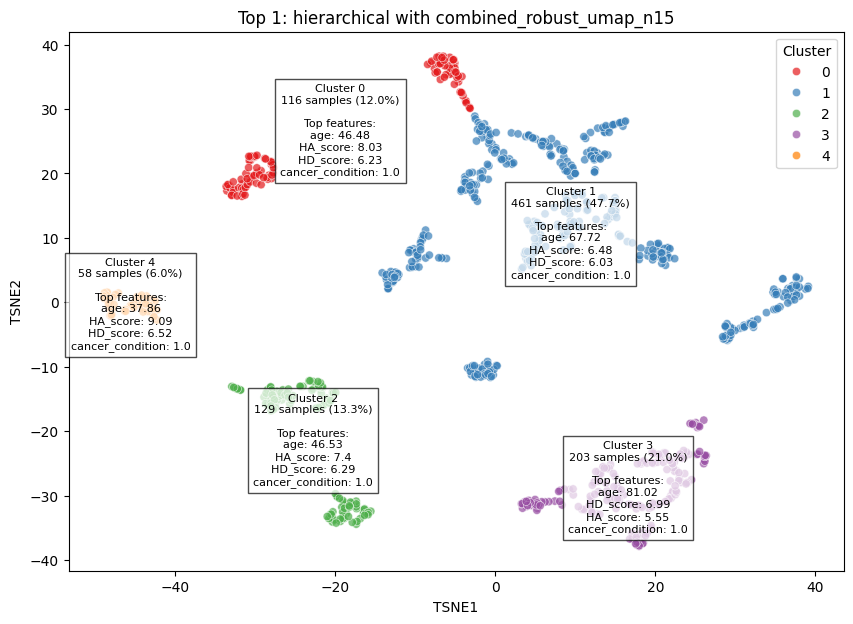


📊 COMPREHENSIVE CLUSTER ANALYSIS REPORT

📈 Overview:

Total clusters identified: 5

Cluster Size Distribution:
+-----------+-----------+--------------+
| Cluster   |   Samples | Percentage   |
+===========+===========+==============+
| Cluster 0 |       116 | 12.0%        |
+-----------+-----------+--------------+
| Cluster 1 |       461 | 47.7%        |
+-----------+-----------+--------------+
| Cluster 2 |       129 | 13.3%        |
+-----------+-----------+--------------+
| Cluster 3 |       203 | 21.0%        |
+-----------+-----------+--------------+
| Cluster 4 |        58 | 6.0%         |
+-----------+-----------+--------------+

--------------------------------------------------------------------------------


🔍 CLUSTER 0 DETAILED ANALYSIS
--------------------------------------------------------------------------------

📊 Numerical Features Analysis:

Significant Features:
+-------------------+-----------------+---------------+--------------------+
| Feature           | Differ

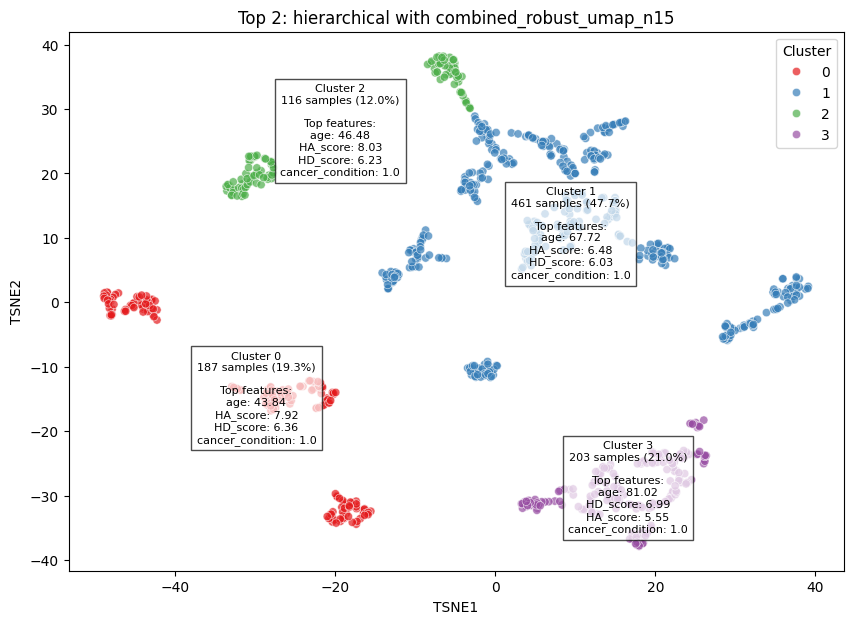


📊 COMPREHENSIVE CLUSTER ANALYSIS REPORT

📈 Overview:

Total clusters identified: 4

Cluster Size Distribution:
+-----------+-----------+--------------+
| Cluster   |   Samples | Percentage   |
+===========+===========+==============+
| Cluster 0 |       187 | 19.3%        |
+-----------+-----------+--------------+
| Cluster 1 |       461 | 47.7%        |
+-----------+-----------+--------------+
| Cluster 2 |       116 | 12.0%        |
+-----------+-----------+--------------+
| Cluster 3 |       203 | 21.0%        |
+-----------+-----------+--------------+

--------------------------------------------------------------------------------


🔍 CLUSTER 0 DETAILED ANALYSIS
--------------------------------------------------------------------------------

📊 Numerical Features Analysis:

Significant Features:
+-------------------+-----------------+---------------+-------------------------+
| Feature           | Difference      |   Effect Size | Significance            |
+===================+==

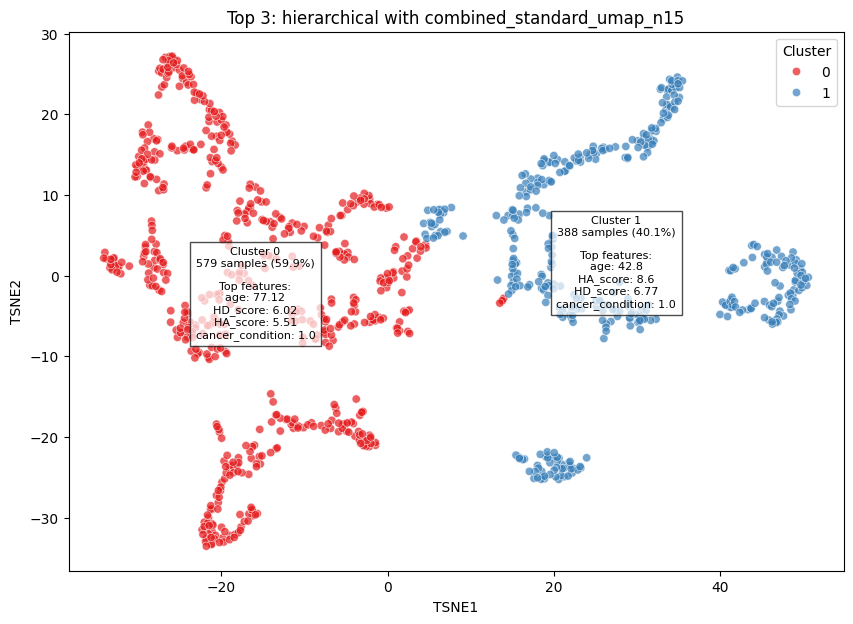


📊 COMPREHENSIVE CLUSTER ANALYSIS REPORT

📈 Overview:

Total clusters identified: 2

Cluster Size Distribution:
+-----------+-----------+--------------+
| Cluster   |   Samples | Percentage   |
+===========+===========+==============+
| Cluster 0 |       579 | 59.9%        |
+-----------+-----------+--------------+
| Cluster 1 |       388 | 40.1%        |
+-----------+-----------+--------------+

--------------------------------------------------------------------------------


🔍 CLUSTER 0 DETAILED ANALYSIS
--------------------------------------------------------------------------------

📊 Numerical Features Analysis:

Significant Features:
+-------------------+----------------+---------------+-------------------------+
| Feature           | Difference     |   Effect Size | Significance            |
+===================+================+===============+=========================+
| age               | 34.32 (+80.2%) |         2.725 | *** (Very Large effect) |
+-------------------+------

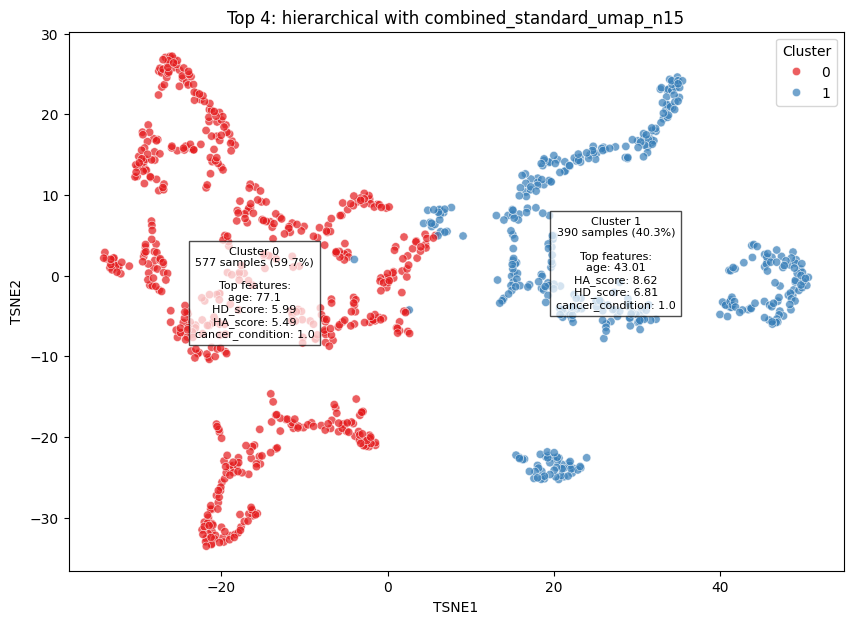


📊 COMPREHENSIVE CLUSTER ANALYSIS REPORT

📈 Overview:

Total clusters identified: 2

Cluster Size Distribution:
+-----------+-----------+--------------+
| Cluster   |   Samples | Percentage   |
+===========+===========+==============+
| Cluster 0 |       577 | 59.7%        |
+-----------+-----------+--------------+
| Cluster 1 |       390 | 40.3%        |
+-----------+-----------+--------------+

--------------------------------------------------------------------------------


🔍 CLUSTER 0 DETAILED ANALYSIS
--------------------------------------------------------------------------------

📊 Numerical Features Analysis:

Significant Features:
+-------------------+----------------+---------------+-------------------------+
| Feature           | Difference     |   Effect Size | Significance            |
+===================+================+===============+=========================+
| age               | 34.09 (+79.3%) |         2.681 | *** (Very Large effect) |
+-------------------+------

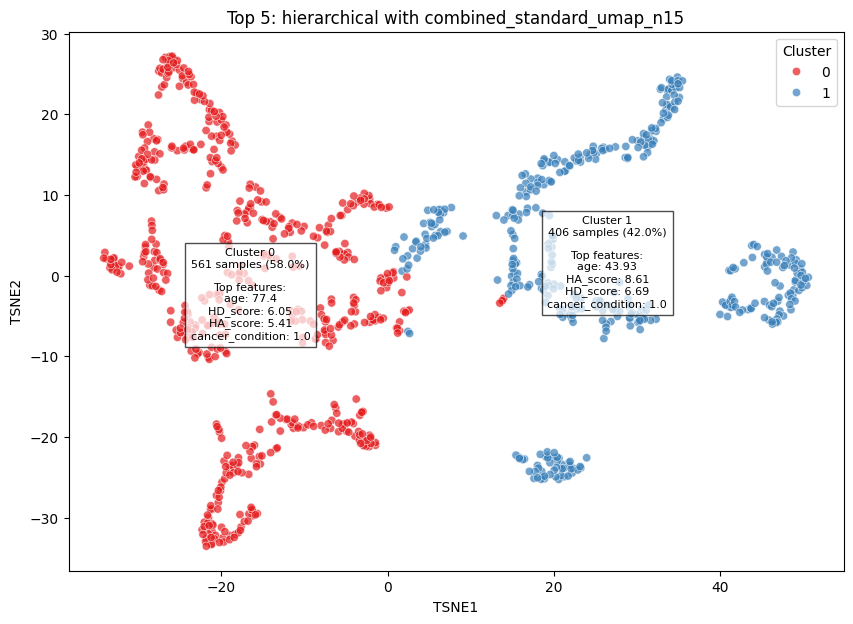


📊 COMPREHENSIVE CLUSTER ANALYSIS REPORT

📈 Overview:

Total clusters identified: 2

Cluster Size Distribution:
+-----------+-----------+--------------+
| Cluster   |   Samples | Percentage   |
+===========+===========+==============+
| Cluster 0 |       561 | 58.0%        |
+-----------+-----------+--------------+
| Cluster 1 |       406 | 42.0%        |
+-----------+-----------+--------------+

--------------------------------------------------------------------------------


🔍 CLUSTER 0 DETAILED ANALYSIS
--------------------------------------------------------------------------------

📊 Numerical Features Analysis:

Significant Features:
+-------------------+----------------+---------------+-------------------------+
| Feature           | Difference     |   Effect Size | Significance            |
+===================+================+===============+=========================+
| age               | 33.47 (+76.2%) |         2.578 | *** (Very Large effect) |
+-------------------+------

In [ ]:
import warnings

import json
import hdbscan
import numpy as np
import pandas as pd
from umap import UMAP
import seaborn as sns
import scipy.stats as stats
from tabulate import tabulate
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA



warnings.filterwarnings('ignore')

def preprocess_data(df, numerical_columns, categorical_columns):
    """
    Clean, scale numerical features, and encode categorical features.
    """
    df_clean = df.copy()

    # Handle numerical columns
    for col in numerical_columns:
        df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)

        col_median = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(col_median)

        # Handle outliers by clipping to +/- 3 std
        col_mean = df_clean[col].mean()
        col_std = df_clean[col].std()
        lower_bound = col_mean - 3 * col_std
        upper_bound = col_mean + 3 * col_std
        df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)

    # Handle categorical columns
    for col in categorical_columns:
        mode_value = df_clean[col].mode().iloc[0]
        df_clean[col] = df_clean[col].fillna(mode_value)
        df_clean[col] = df_clean[col].astype('category')

    # different scaling methods
    scalers = {
        'standard': StandardScaler(),
        'robust': RobustScaler(quantile_range=(1, 99)),
        'minmax': MinMaxScaler(feature_range=(-1, 1))
    }

    processed_data_list = []
    for scaler_name, scaler in scalers.items():
        scaled_numerical = scaler.fit_transform(df_clean[numerical_columns])

        # frequency encoding
        categorical_encoded = pd.DataFrame()
        for col in categorical_columns:
            freq_encoding = df_clean[col].map(df_clean[col].value_counts(normalize=True))
            categorical_encoded[col] = freq_encoding

        combined_data = np.hstack((scaled_numerical, categorical_encoded.values))
        combined_data = np.nan_to_num(combined_data, nan=0.0, posinf=1.0, neginf=-1.0)

        processed_data_list.append({'data': combined_data, 'method': f'combined_{scaler_name}'})

    return processed_data_list

def reduce_dimensions(data, n_components=10):
    """
    PCA and UMAP.
    """
    reduced_datasets = []

    # PCA reduction
    from sklearn.decomposition import PCA
    pca = PCA(n_components=min(data.shape[1], n_components), random_state=42)
    pca_data = pca.fit_transform(data)
    reduced_datasets.append({'data': pca_data, 'method': 'pca'})

    # UMAP reductions with different parameters
    umap_params = [
        {'n_neighbors': 15, 'min_dist': 0.1},
        {'n_neighbors': 30, 'min_dist': 0.5}
    ]

    for params in umap_params:
        umap = UMAP(n_components=min(data.shape[1], n_components),
                    random_state=42, **params)
        umap_data = umap.fit_transform(data)
        reduced_datasets.append({
            'data': umap_data,
            'method': f'umap_n{params["n_neighbors"]}'
        })

    return reduced_datasets

def perform_clustering(data):
    """
    Hierarchical clustering and HDBSCAN.
    """
    results = []

    # Hierarchical clustering
    for linkage in ['ward', 'complete', 'average']:
        for n_clusters in range(2, 6):
            clustering = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage
            )
            labels = clustering.fit_predict(data)

            if len(set(labels)) < 2:
                continue

            metrics = calculate_cluster_metrics(data, labels)

            results.append({
                'method': 'hierarchical',
                'params': {'linkage': linkage, 'n_clusters': n_clusters},
                'labels': labels,
                **metrics
            })

    # HDBSCAN clustering
    for min_cluster_size in [10, 20, 30]:
        clustering = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=5,
            cluster_selection_method='eom'
        )
        labels = clustering.fit_predict(data)

        # Skip if too many noise points
        if len(set(labels)) < 2 or (labels == -1).sum() / len(labels) > 0.1:
            continue

        metrics = calculate_cluster_metrics(data, labels)

        results.append({
            'method': 'hdbscan',
            'params': {'min_cluster_size': min_cluster_size},
            'labels': labels,
            **metrics
        })

    return results

def calculate_cluster_metrics(data, labels):

    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)

    combined_score = (
        0.4 * silhouette +
        0.4 * (calinski / max(1000, calinski)) +
        0.2 * (1 / (1 + davies))
    )

    return {
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies,
        'combined_score': combined_score
    }

def plot_clusters_with_annotations(data, labels, df_original, title):

    # t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42).fit_transform(data)
    tsne_df = pd.DataFrame(tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['Cluster'] = labels

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=tsne_df,
                    palette='Set1', legend='full', alpha=0.7)

    # Add cluster text
    for cluster in sorted(set(labels)):
        cluster_points = tsne_df[tsne_df['Cluster'] == cluster]
        center = cluster_points[['TSNE1', 'TSNE2']].mean()

        cluster_size = len(cluster_points)
        percentage = (cluster_size / len(df_original)) * 100

        cluster_data = df_original.iloc[cluster_points.index]

        feature_summary = {}
        for col in cluster_data.columns:
            if cluster_data[col].dtype in [np.float64]:  # Numerical
                feature_summary[col] = cluster_data[col].mean()
            elif cluster_data[col].dtype == 'object' or cluster_data[col].dtype.name == 'category':  # Categorical
                most_common = cluster_data[col].mode().iloc[0]
                freq = (cluster_data[col] == most_common).sum() / cluster_size
                feature_summary[col] = freq  # Use frequency as a score
            numerical_summary = cluster_data.select_dtypes(include=[np.number]).describe().T
            top_numerical_features = numerical_summary['mean'].sort_values(ascending=False).head(3)

        top_features = sorted(feature_summary.items(), key=lambda x: x[1], reverse=True)[:4]

        annotation = f"Cluster {cluster}\n{cluster_size} samples ({percentage:.1f}%)"
        annotation += "\n\nTop features:\n"
        annotation += "\n".join([f"{feature}: {round(score, 2) if isinstance(score, float) else score}" for feature, score in top_features])

        plt.annotate(annotation, (center['TSNE1'], center['TSNE2']),
                     horizontalalignment='center', verticalalignment='center',
                     fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

    plt.title(title)
    plt.show()

def interpret_effect_size(value: float, metric: str = 'cohens_d') -> str:

    if metric == 'cohens_d':
        if abs(value) >= 1.2: return 'Very Large'
        if abs(value) >= 0.8: return 'Large'
        if abs(value) >= 0.5: return 'Medium'
        if abs(value) >= 0.2: return 'Small'
        return 'Negligible'
    elif metric == 'cramers_v':
        if value >= 0.35: return 'Very Large'
        if value >= 0.25: return 'Large'
        if value >= 0.15: return 'Medium'
        if value >= 0.05: return 'Small'
        return 'Negligible'
    return 'Unknown'

def format_significance(p_value: float, effect_size: float, effect_type: str) -> str:

    sig_symbol = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    effect_interp = interpret_effect_size(effect_size, effect_type)
    return f"{sig_symbol} ({effect_interp} effect)"

def create_feature_summary_table(data: List[Dict], headers: List[str]) -> str:

    # Convert list of dicts to list of lists
    table_data = []
    for row in data:
        table_row = []
        for header in headers:
            table_row.append(row.get(header, ''))
        table_data.append(table_row)

    return tabulate(table_data, headers=headers, tablefmt='grid', floatfmt='.3f')

def save_results_to_json(results: Dict, output_file: str):

    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)

def analyze_numerical_feature(cluster_data: pd.DataFrame,
                            other_data: pd.DataFrame,
                            feature: str) -> Dict:

    # Basic statistics
    cluster_mean = cluster_data[feature].mean()
    other_mean = other_data[feature].mean()
    diff = cluster_mean - other_mean

    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(cluster_data) - 1) * cluster_data[feature].var() +
                         (len(other_data) - 1) * other_data[feature].var()) /
                        (len(cluster_data) + len(other_data) - 2))
    cohens_d = diff / pooled_std if pooled_std > 0 else 0

    # Statistical tests
    t_stat, p_value = stats.ttest_ind(cluster_data[feature], other_data[feature])

    return {
        'mean': cluster_mean,
        'diff': diff,
        'diff_percent': (diff / other_mean * 100) if other_mean != 0 else np.inf,
        'cohens_d': cohens_d,
        'p_value': p_value,
        't_stat': t_stat
    }

def analyze_categorical_feature(cluster_data: pd.DataFrame,
                              full_data: pd.DataFrame,
                              feature: str) -> Dict:

    cluster_indicator = full_data['Cluster'] == cluster_data['Cluster'].iloc[0]
    contingency = pd.crosstab(full_data[feature], cluster_indicator)

    # chi-square
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

    # Cramer's V
    n = contingency.sum().sum()
    min_dim = min(contingency.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if n * min_dim > 0 else 0

    cluster_props = cluster_data[feature].value_counts(normalize=True)
    overall_props = full_data[feature].value_counts(normalize=True)

    category_differences = []
    for category in set(cluster_props.index) | set(overall_props.index):
        cluster_prop = cluster_props.get(category, 0)
        overall_prop = overall_props.get(category, 0)
        diff = cluster_prop - overall_prop
        category_differences.append({
            'category': str(category),  # Convert category to string to handle non-string categories
            'difference': diff,
            'cluster_prop': cluster_prop,
            'overall_prop': overall_prop
        })

    return {
        'chi2': chi2,
        'p_value': p_value,
        'cramers_v': cramers_v,
        'categories': sorted(category_differences, key=lambda x: abs(x['difference']), reverse=True)
    }

def analyze_clusters(df: pd.DataFrame,
                    labels: np.ndarray,
                    numerical_columns: List[str],
                    categorical_columns: List[str],
                    output_file: str = 'cluster_analysis.json') -> Dict:

    df = df.copy()
    df['Cluster'] = labels
    results = {}

    print("\n" + "="*80)
    print("📊 COMPREHENSIVE CLUSTER ANALYSIS REPORT")
    print("="*80 + "\n")

    n_clusters = len(set(labels))
    print(f"📈 Overview:\n")
    print(f"Total clusters identified: {n_clusters}")
    cluster_sizes = pd.Series(labels).value_counts().sort_index()

    # Create size data as list of dictionaries
    size_data = [
        {
            "Cluster": f"Cluster {cluster}",
            "Samples": size,
            "Percentage": f"{(size / len(df) * 100):.1f}%"
        }
        for cluster, size in cluster_sizes.items()
    ]

    print("\nCluster Size Distribution:")
    print(create_feature_summary_table(size_data, ["Cluster", "Samples", "Percentage"]))
    print("\n" + "-"*80 + "\n")

    # Analyze each cluster
    for cluster in sorted(set(labels)):
        print(f"\n🔍 CLUSTER {cluster} DETAILED ANALYSIS")
        print("-"*80)

        cluster_data = df[df['Cluster'] == cluster].copy()
        other_data = df[df['Cluster'] != cluster].copy()

        cluster_info = {
            'size': len(cluster_data),
            'percentage': (len(cluster_data) / len(df)) * 100,
            'numerical_features': {},
            'categorical_features': {}
        }

        # Numerical Features Analysis
        print("\n📊 Numerical Features Analysis:")
        numerical_results = []

        for feature in numerical_columns:
            stats = analyze_numerical_feature(cluster_data, other_data, feature)
            cluster_info['numerical_features'][feature] = stats

            if stats['p_value'] < 0.05:  # Only show significant features
                numerical_results.append({
                    'Feature': feature,
                    'Difference': f"{stats['diff']:.2f} ({stats['diff_percent']:+.1f}%)",
                    'Effect Size': f"{stats['cohens_d']:.3f}",
                    'Significance': format_significance(stats['p_value'], stats['cohens_d'], 'cohens_d')
                })

        if numerical_results:
            print("\nSignificant Features:")
            print(create_feature_summary_table(numerical_results,
                ['Feature', 'Difference', 'Effect Size', 'Significance']))
            print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns: not significant")
        else:
            print("\nNo significant numerical features found.")

        # Categorical Features Analysis
        print("\n📋 Categorical Features Analysis:")
        categorical_results = []

        for feature in categorical_columns:
            if feature in df.columns:
                stats = analyze_categorical_feature(cluster_data, df, feature)
                cluster_info['categorical_features'][feature] = stats

                if stats['p_value'] < 0.05:  # Only show significant features
                    formatted_differences = []
                    for cat in stats['categories'][:3]:  # Show top 3 distinctive categories
                        diff_percent = cat['difference'] * 100
                        if abs(diff_percent) > 5:  # Only show meaningful differences
                            direction = "more" if diff_percent > 0 else "less"
                            formatted_differences.append(
                                f"{cat['category']}: {abs(diff_percent):.1f}% {direction} frequent"
                            )

                    if formatted_differences:  # Only add to results if there are meaningful differences
                        categorical_results.append({
                            'Feature': feature,
                            'Top Differences': '\n'.join(formatted_differences),
                            'Effect Size': f"{stats['cramers_v']:.3f}",
                            'Significance': format_significance(stats['p_value'], stats['cramers_v'], 'cramers_v')
                        })

        if categorical_results:
            print("\nSignificant Features:")
            print(create_feature_summary_table(categorical_results,
                ['Feature', 'Top Differences', 'Effect Size', 'Significance']))
            print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns: not significant")
        else:
            print("\nNo significant categorical features found.")

        # Store results for JSON
        results[f'cluster_{cluster}'] = cluster_info

    # Save to JSON
    save_results_to_json(results, output_file)

    return results

def run_clustering_analysis(df, numerical_columns, categorical_columns):
    """
    Main function.
    """
    print("Starting clustering analysis...")
    print("\nPreprocessing data...")
    processed_data_list = preprocess_data(df, numerical_columns, categorical_columns)

    print("Reducing dimensions...")
    reduced_datasets = []
    for data_info in processed_data_list:
        data = data_info['data']
        method = data_info['method']
        reduced_data_versions = reduce_dimensions(data)
        for reduced_data in reduced_data_versions:
            reduced_data['method'] = f"{method}_{reduced_data['method']}"
            reduced_datasets.append(reduced_data)

    print("Performing clustering...")
    all_results = []
    for dataset in reduced_datasets:
        data = dataset['data']
        method_name = dataset['method']
        results = perform_clustering(data)
        for result in results:
            result['reduction_method'] = method_name
            result['data'] = data
        all_results.extend(results)

    # top results
    top_results = sorted(all_results, key=lambda x: x['combined_score'], reverse=True)[:5]

    print("\n=== Top Clustering Results ===")
    for i, result in enumerate(top_results, 1):
        print(f"\nRank {i}:")
        print(f"Method: {result['method']} with {result['reduction_method']}")
        print(f"Parameters: {result['params']}")
        print(f"Metrics:")
        print(f"- Silhouette: {result['silhouette']:.3f}")
        print(f"- Calinski-Harabasz: {result['calinski']:.3f}")
        print(f"- Davies-Bouldin: {result['davies']:.3f}")

        # Visualize
        plot_clusters_with_annotations(
            result['data'],
            result['labels'],
            df,
            f"Top {i}: {result['method']} with {result['reduction_method']}"
        )

        # Analyze
        analyze_clusters(
            df,
            result['labels'],
            numerical_columns,
            categorical_columns
        )

    return top_results

# Run
if __name__ == "__main__":
    processed_url = '<INSERT_PRIVATE_DATA_LINK>    df = pd.read_csv(processed_url)

    categorical_columns = [
        'sex', 'HA1_I_feel_tense_or_wound_up', 'HA2_I_get_a_sort_of_frightened_feeling_as_if_something_awful_is_about_to_happen',
        'HA3_Worrying_thoughts_go_through_my_mind', 'HA4_I_can_sit_at_ease_and_feel_relaxed',
        'HA5_I_get_a_sort_of_frightened_feeling_like_butterflies_in_the_stomach',
        'HA6_I_feel_restless_as_if_I_have_to_be_on_the_move', 'HA7_I_get_sudden_feelings_of_panic',
        'HD1_I_still_enjoy_the_things_I_used_to_enjoy', 'HD2_I_can_laugh_and_see_the_funny_side_of_things',
        'HD3_I_feel_cheerful', 'HD4_I_feel_as_if_I_am_slowed_down', 'HD5_I_have_lost_interest_in_my_appearance',
        'HD6_I_look_forward_with_enjoyment_to_things', 'HD7_I_can_enjoy_a_good_book_or_radio_or_TV_program',
        'cancer_condition', 'consequences_of_drug_use', 'control_over_drug_use',
        'current_drug_use', '20+_years_smoker', 'current_smoker', 'fall_frequent_severe',
        'fall_history', 'good_balance_performance', 'help_seeking_behavior_drug_use',
        'left_handed', 'major_organ_condition', 'mobility_pain_condition', 'past_drug_use',
        'processed_meat_consumption', 'right_handed', 'severe_chronic_condition',
        'smi_psychiatric_condition', 'soft_psychiatric_condition', 'sp_insomnia', 'stroke_condition',
        'trouble_sleeping', 'place_of_birth', 'ethnic_group', 'marital_status', 'uk_born',
        'local_mother_tongue', 'abstract_thinking_score', 'alcohol_consumption', 'attention_concentration_score',
        'balance_test_participation', 'calculation_score', 'current_memory_score', 'fruit_veg_intake',
        'independence_level_higherisbetter', 'insufficient_sleep', 'irregular_sleep_patterns',
        'language_comprehension_score', 'language_naming_score', 'language_reading_score',
        'language_repetition_score', 'language_writing_score', 'memory_perception_score', 'memory_recall_score',
        'orientation_score', 'perceptual_abilities_score', 'quality_sleep', 'registration_score',
        'verbal_fluency_score', 'visuospatial_score', 'social_isolation', 'income', 'education', 'sp_hypersomnia'
    ]

    numerical_columns = [
        'age', 'ChoiceRT_accuracy', 'ChoiceRT_median', 'SimpleRT_median', 'HD_score', 'HA_score'
    ]

    for col in categorical_columns:
        df[col] = df[col].astype('category')
    df['ID'] = df['ID'].astype('category')

    for col in numerical_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df[df['HD_score'] >= 4]

    for col in numerical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)

    for col in categorical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

    ids = df['ID']
    df = df.drop(columns=['ID'])

    print("Number of samples:", len(df))
    print("Number of features:", len(numerical_columns) + len(categorical_columns))

    # Run the analysis
    results = run_clustering_analysis(df, numerical_columns, categorical_columns)
